In [1]:
from metric_learn.lmnn import LMNN
from metric_learn.covariance import Covariance
from metric_learn.mlkr import MLKR
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(9999999)

In [2]:
# Load all of the saved files
train_feat = np.loadtxt('train_feat.gzip', dtype = 'float')
gallery_feat = np.loadtxt('gallery_feat.gzip', dtype = 'float')
query_feat = np.loadtxt('query_feat.gzip', dtype = 'float')
val_feat = np.loadtxt('val_feat.gzip', dtype = 'float')
train_noval_feat = np.loadtxt('train_noval_feat.gzip', dtype = 'float')
train_labels = np.loadtxt('train_labels.gzip', dtype = 'uint16')
gallery_labels = np.loadtxt('gallery_labels.gzip', dtype = 'uint16')
query_labels = np.loadtxt('query_labels.gzip', dtype = 'uint16')
val_labels = np.loadtxt('val_labels.gzip', dtype = 'uint16')
train_noval_labels = np.loadtxt('train_noval_labels.gzip', dtype = 'uint16')
#train_filelist = np.loadtxt('train_filelist.gzip', dtype = 'uint16')
#gallery_filelist = np.loadtxt('gallery_filelist.gzip', dtype = 'uint16')
#query_filelist = np.loadtxt('query_filelist.gzip', dtype = 'uint16')
#val_filelist = np.loadtxt('val_filelist.gzip', dtype = 'uint16')
#train_noval_filelist = np.loadtxt('train_noval_filelist.gzip', dtype = 'uint16')
train_camId = np.loadtxt('train_camId.gzip', dtype = 'uint16') # uint8
gallery_camId = np.loadtxt('gallery_camId.gzip', dtype = 'uint16')
query_camId = np.loadtxt('query_camId.gzip', dtype = 'uint16')
val_camId = np.loadtxt('val_camId.gzip', dtype = 'uint16')
train_noval_camId = np.loadtxt('train_noval_camId.gzip', dtype = 'uint16')

In [3]:
#Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)
print(val_pair_unique, val_pair_unique_indxs, val_pair_unique.shape)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

print(val_feat.shape, val_labels.shape)
print(val_query_feat.shape, val_query_labels.shape, val_query_camId.shape, val_gallery_feat.shape, val_gallery_labels.shape, val_gallery_camId.shape)


[[   9    9   12   12   18   18   20   20   27   27   36   36   43   43
    48   48   49   49   53   53   61   61   67   67   73   73   84   84
    90   90   94   94   95   95  106  106  118  118  155  155  169  169
   173  173  200  200  251  251  252  252  253  253  282  282  305  305
   314  314  323  323  364  364  403  403  420  420  481  481  489  489
   514  514  539  539  543  543  554  554  602  602  610  610  615  615
   621  621  629  629  642  642  654  654  659  659  668  668  701  701
   713  713  747  747  766  766  777  777  782  782  788  788  791  791
   801  801  803  803  810  810  811  811  813  813  815  815  878  878
   906  906  921  921  978  978  981  981  990  990  993  993 1051 1051
  1079 1079 1083 1083 1086 1086 1110 1110 1118 1118 1130 1130 1152 1152
  1157 1157 1160 1160 1165 1165 1171 1171 1183 1183 1185 1185 1198 1198
  1236 1236 1238 1238 1261 1261 1269 1269 1287 1287 1288 1288 1290 1290
  1291 1291 1341 1341 1348 1348 1363 1363 1366 1366 1383 1383 13

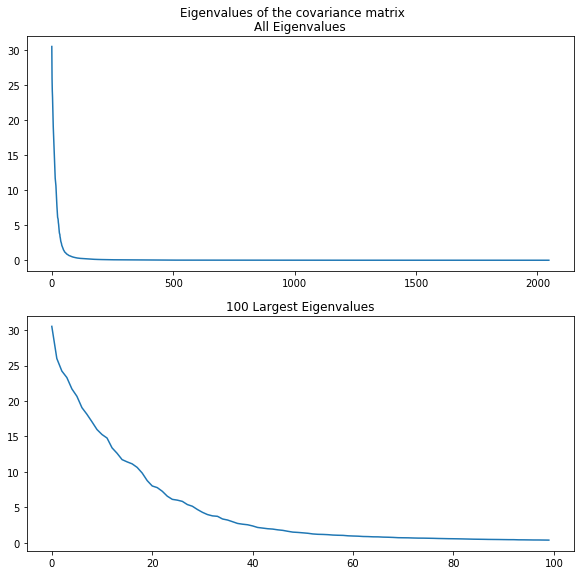

Percentage of total data variance captured: 0.9902873121403473


In [4]:
#DO PCA
pca_train_noval =PCA()
pca_train_noval.fit(train_noval_feat)
pca_train_noval_eigvals = pca_train_noval.explained_variance_

x = np.arange(0, pca_train_noval_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_noval_eigvals, '-')
axs[0].set_title('All Eigenvalues')

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_noval_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
plt.show()

print("Percentage of total data variance captured:", 
      (np.sum(pca_train_noval_eigvals[:500]))/(np.sum(pca_train_noval_eigvals[:500])+np.sum(pca_train_noval_eigvals[500:])))

In [5]:
pca = PCA(n_components=500)
#train_noval_feat_reduced = pca.fit_transform(train_noval_feat)
train_feat_reduced = pca.fit_transform(train_feat)
query_feat_reduced = pca.transform(query_feat)
gallery_feat_reduced = pca.transform(gallery_feat)

In [6]:
# Create a dict storing the differently transformed features
feat_dict_val = {}
#feat_dict_val["basecase"] = (val_query_feat, val_gallery_feat)

feat_dict = {}
feat_dict["basecase"] = (query_feat, gallery_feat)

In [7]:
Cov_Model = Covariance().fit(train_feat, train_labels)
query_feat_Cov = Cov_Model.transform(query_feat)
gallery_feat_Cov = Cov_Model.transform(gallery_feat)

feat_dict["Covariance"]=(query_feat_Cov, gallery_feat_Cov)

In [8]:
Cov_Model_red = Covariance().fit(train_feat_reduced, train_labels)
query_feat_Cov_red = Cov_Model_red.transform(query_feat_reduced)
gallery_feat_Cov_red = Cov_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA Covariance"]=(query_feat_Cov_red, gallery_feat_Cov_red)

In [9]:
LargeMarg_Model = LMNN(verbose=True).fit(train_feat,train_labels)
query_feat_LMNN = LargeMarg_Model.transform(query_feat)
gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat)

feat_dict["LMNN"]=(query_feat_LMNN, gallery_feat_LMNN)

#val_query_feat_M = M.transform(val_query_feat)
#val_gallery_feat_M = M.transform(val_gallery_feat)

#feat_dict_val["LMNN"]=(val_query_feat_M,val_gallery_feat_M)

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 765604.8409514618 -2816.713554516202 28 1.0099999999999999e-07
3 762768.9081833549 -2835.9327681069262 27 1.0201e-07
4 759915.330559735 -2853.577623619931 27 1.030301e-07
5 757042.9118664912 -2872.4186932437588 26 1.0406040099999999e-07
6 754152.8838508244 -2890.0280156667577 25 1.0510100500999999e-07
7 751245.2307615683 -2907.6530892561423 24 1.0615201506009999e-07
8 748319.1061694798 -2926.124592088512 24 1.0721353521070098e-07
9 745375.006323377 -2944.099846102763 22 1.08285670562808e-07
10 742414.2419775834 -2960.7643457936356 21 1.0936852726843608e-07
11 739435.3387439452 -2978.9032336381497 21 1.1046221254112044e-07
12 736437.786481913 -2997.552262032288 19 1.1156683466653164e-07
13 733422.8023871656 -3014.984094747342 19 1.1268250301319696e-07
14 730388.6561803278 -3034.146206837846 19 1.1380932804332893e-07
15 727335.3770936304 -3053.279086697381 19 1.1494742132376222e-07
16 724262.9990907772 -3072.378002853133 19 1.1609689553699984e-07
17 721171.7668415101 -3091.232249267166

128 336019.60411245143 -2195.833083941019 0 3.538461465303104e-07
129 333908.6814979336 -2110.9226145178545 0 3.573846079956135e-07
130 331885.6665204178 -2023.0149775157915 0 3.6095845407556966e-07
131 329953.6294952234 -1932.0370251943823 0 3.645680386163254e-07
132 328115.7154847261 -1837.9140104972757 0 3.6821371900248867e-07
133 326375.14593110955 -1740.569553616573 0 3.7189585619251353e-07
134 324735.2203232434 -1639.925607866142 0 3.7561481475443865e-07
135 323199.3178983738 -1535.9024248695932 0 3.7937096290198303e-07
136 321770.89937935624 -1428.4185190175776 0 3.8316467253100284e-07
137 320453.5087481453 -1317.390631210932 0 3.8699631925631286e-07
138 319250.7750562849 -1202.7336918603978 0 3.9086628244887597e-07
139 318166.414273167 -1084.3607831178815 0 3.947749452733647e-07
140 317204.2311728171 -962.1831003499101 0 3.987226947260984e-07
141 316368.12126000324 -836.109912813874 0 4.027099216733594e-07
142 315662.07273647364 -706.0485235296073 0 4.0673702089009297e-07
143 3

In [10]:
LargeMarg_Model_red = LMNN(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_LMNN_red = LargeMarg_Model_red.transform(query_feat_reduced)
gallery_feat_LMNN_red = LargeMarg_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA LMNN"]=(query_feat_LMNN_red, gallery_feat_LMNN_red)

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 699943.9934328948 -2792.9153289493406 28 1.0099999999999999e-07
3 697131.9816125379 -2812.0118203569436 28 1.0201e-07
4 694301.3724548388 -2830.609157699044 27 1.030301e-07
5 691452.6919319689 -2848.680522869923 27 1.0406040099999999e-07
6 688585.6876787697 -2867.0042531992076 25 1.0510100500999999e-07
7 685702.0813561846 -2883.6063225851394 24 1.0615201506009999e-07
8 682800.3515134689 -2901.729842715664 24 1.0721353521070098e-07
9 679879.904385034 -2920.4471284348983 23 1.08285670562808e-07
10 676942.2580960748 -2937.646288959193 22 1.0936852726843608e-07
11 673986.4902624649 -2955.767833609949 21 1.1046221254112044e-07
12 671012.7710029699 -2973.7192594949156 20 1.1156683466653164e-07
13 668021.2335943952 -2991.537408574717 19 1.1268250301319696e-07
14 665012.001002009 -3009.2325923861936 19 1.1380932804332893e-07
15 661983.764751033 -3028.236250975984 19 1.1494742132376222e-07
16 658936.5576870958 -3047.2070639372105 19 1.1609689553699984e-07
17 655870.4174642126 -3066.1402228832

128 273204.7318872608 -2195.6154460924445 0 3.538461465303104e-07
129 271092.9016224293 -2111.8302648314857 0 3.573846079956135e-07
130 269067.81979151897 -2025.0818309103488 0 3.6095845407556966e-07
131 267132.52200027456 -1935.297791244404 0 3.645680386163254e-07
132 265290.1177897378 -1842.4042105367407 0 3.6821371900248867e-07
133 263543.792251544 -1746.325538193807 0 3.7189585619251353e-07
134 261896.80767697722 -1646.984574566799 0 3.7561481475443865e-07
135 260352.5052404756 -1544.3024365016026 0 3.7937096290198303e-07
136 258914.30671829436 -1438.1985221812502 0 3.8316467253100284e-07
137 257585.71624304453 -1328.5904752498318 0 3.8699631925631286e-07
138 256370.3220948415 -1215.3941482030204 0 3.9086628244887597e-07
139 255271.79852981493 -1098.5235650265822 0 3.947749452733647e-07
140 254293.9076467421 -977.8908830728324 0 3.987226947260984e-07
141 253440.50129258676 -853.4063541553332 0 4.027099216733594e-07
142 252715.5230077364 -724.9782848503673 0 4.0673702089009297e-07
1

In [11]:
MLKR_Model = MLKR(verbose=True).fit(train_feat,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat)

feat_dict["MLKR"]=(query_feat_MLKR, gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      28.08
[MLKR] Training took    30.53s.


In [12]:
MLKR_Model_red = MLKR(verbose=True).fit(train_feat_reduced,train_labels)
query_feat_MLKR_red = MLKR_Model_red.transform(query_feat_reduced)
gallery_feat_MLKR_red = MLKR_Model_red.transform(gallery_feat_reduced)

feat_dict["PCA MLKR"]=(query_feat_MLKR_red, gallery_feat_MLKR_red)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      10.15
[MLKR] Training took    10.41s.


In [13]:
#M_reduced = LMNN(verbose=True).fit(train_noval_feat_reduced,train_noval_labels)

#val_query_feat_reduced = pca.transform(val_query_feat)
#val_gallery_feat_reduced = pca.transform(val_gallery_feat)
#print(val_query_feat_reduced.shape, val_gallery_feat_reduced.shape)

#val_query_feat_M_reduced = M_reduced.transform(val_query_feat_reduced)
#val_gallery_feat_M_reduced = M_reduced.transform(val_gallery_feat_reduced)

#feat_dict_val["LMNN reduced"]=(val_query_feat_M_reduced,val_gallery_feat_M_reduced)

In [14]:
# Function that takes as input an index that refers to a query image
# and returns the val_gallery without the unnecessary pictures in it
# Remove the pictures from the gallery that have the same label and are taken by the same camera as out VAL_QUERY[index]
# picture in the query array
def get_removed_val_gallery (index, t_gallery_feat):
    selected_indices = np.logical_not(np.logical_and(val_gallery_camId == val_query_camId[index], val_gallery_labels == val_query_labels[index]))
    return t_gallery_feat[selected_indices, :], val_gallery_labels[selected_indices], val_gallery_camId[selected_indices]

In [15]:
for key, (t_query_feat, t_gallery_feat) in feat_dict_val.items():
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((val_query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((val_query_labels.shape[0],k))

    for i in range (0, val_query_labels.shape[0], 1):
        gallery_feat_removed, gallery_labels_removed, gallery_camId_removed = get_removed_val_gallery (i, t_gallery_feat)
        nbrs = NearestNeighbors(n_neighbors=k).fit(gallery_feat_removed)
        distances, indices = nbrs.kneighbors(t_query_feat[i:i+1, :])
        print(gallery_labels_removed[indices], val_query_labels[i])
        print("camIds:", gallery_camId_removed[indices], val_query_camId[i])
        is_same_label = (val_query_labels[i] == gallery_labels_removed[indices])
    
        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[0, :(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[0, :(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[0, :(j+1)])/np.sum(gallery_labels_removed==val_query_labels[i])

    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print ("Mean average precision:", average_precisions.mean())
    

In [16]:
# Function that takes as input an index that refers to a query image
# and returns the gallery without the unnecessary pictures in it
# Remove the pictures from the gallery that have the same label and are taken by the same camera as out QUERY[index]
# picture in the query array
def get_removed_gallery (index, t_gallery_feat):
    selected_indices = np.logical_not(np.logical_and(gallery_camId == query_camId[index], gallery_labels == query_labels[index]))
    return t_gallery_feat[selected_indices, :], gallery_labels[selected_indices], gallery_camId[selected_indices]

In [17]:
for key, (t_query_feat, t_gallery_feat) in feat_dict.items():
    # k nearest neighbours implementation
    k = 10
    top_k_accuracies_rank = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_classical = np.zeros((query_labels.shape[0],k))
    top_k_accuracies_recall = np.zeros((query_labels.shape[0],k))

    for i in range (0, query_labels.shape[0], 1):
        gallery_feat_removed, gallery_labels_removed, gallery_camId_removed = get_removed_gallery (i, t_gallery_feat)
        nbrs = NearestNeighbors(n_neighbors=k).fit(gallery_feat_removed)
        distances, indices = nbrs.kneighbors(t_query_feat[i:i+1, :])
        print(gallery_labels_removed[indices], query_labels[i])
        print("camIds:", gallery_camId_removed[indices], query_camId[i])
        is_same_label = (query_labels[i] == gallery_labels_removed[indices])
    
        for j in range (0, k, 1):
            top_k_accuracies_rank[i,j] = np.sum(is_same_label[0, :(j+1)]) != 0
            top_k_accuracies_classical[i,j]=np.sum(is_same_label[0, :(j+1)])/(j+1)
            top_k_accuracies_recall[i,j] = np.sum(is_same_label[0, :(j+1)])/np.sum(gallery_labels_removed==query_labels[i])

    average_precisions = np.zeros((query_labels.shape))
    for j in range (0, query_labels.shape[0], 1):
        recall = top_k_accuracies_recall[j, :]
        precision = top_k_accuracies_classical[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    print (key, "Mean average precision:", average_precisions.mean())

[[1368  739 1426   51 1368   14   14 1450   51 1368]] 3
camIds: [[1 1 2 2 1 1 1 1 1 1]] 1
[[ 517  235  235 1426  725   86   51 1426  172    3]] 3
camIds: [[1 1 1 2 1 1 1 2 1 1]] 2
[[  6   6   6   6 678  77  77 678 678 648]] 6
camIds: [[2 2 2 2 2 1 1 2 1 1]] 1
[[  6   6   6   6 678 678 678 678 678  72]] 6
camIds: [[1 1 1 1 1 2 1 2 2 1]] 2
[[ 22   7 382  22   7 303   7 854   7 441]] 7
camIds: [[1 2 1 1 2 1 2 2 2 1]] 1
[[319 319   7 319   7   7   7 319  22  22]] 7
camIds: [[2 2 1 2 1 1 1 2 1 1]] 2
[[390 738  11 738  11  55  11 625 211  42]] 11
camIds: [[2 1 2 1 2 1 2 1 2 2]] 1
[[738  55 721  11 721 721 401 721 738 763]] 11
camIds: [[2 1 2 1 2 2 2 1 2 2]] 2
[[ 14  14   3  51  14  51  51 182 650  51]] 14
camIds: [[2 2 1 1 2 2 1 1 1 1]] 1
[[ 14  14  14  14 739 291  51 182 182 739]] 14
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 17  17  17  17  32 715  32  32  68  68]] 17
camIds: [[2 2 2 2 1 2 1 1 1 1]] 1
[[ 17  17  17  17 715  32 715  32 115 715]] 17
camIds: [[1 1 1 1 2 1 1 2 1 2]] 2
[[ 17  17  17 

[[727   3   3 769 575 769 769 725 727   3]] 119
camIds: [[1 1 1 2 2 1 1 1 1 1]] 1
[[727 727 727 303 303 303 695 303 174 303]] 119
camIds: [[2 2 2 2 2 2 2 1 2 1]] 2
[[1389    3  979  979  404  404 1098  404    3 1098]] 120
camIds: [[2 2 1 1 2 2 2 2 2 2]] 1
[[267 646 646 509 646 120 646 120 267 171]] 120
camIds: [[1 2 2 1 2 1 2 1 1 2]] 2
[[121 121 578 923 578 558 923 558 578 923]] 121
camIds: [[2 2 2 2 2 1 2 1 2 2]] 1
[[ 121  121  121 1187 1187  558 1187  599  558  653]] 121
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[123 123 123 450 123 134 220 134 149 988]] 123
camIds: [[2 2 2 1 2 1 2 1 1 1]] 1
[[123 859 381 149 699 859 699 123 400 400]] 123
camIds: [[1 1 2 1 1 1 1 1 1 1]] 2
[[127 127 127 127 494 653 437 732 349  86]] 127
camIds: [[2 2 2 2 1 2 1 1 1 2]] 1
[[127 127 127 127 732 732 732 732 143 143]] 127
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[128 823 163 552 128 504 552 163 128 823]] 128
camIds: [[2 1 2 1 2 1 1 2 2 1]] 1
[[128 128 129 241 128 128 738 241 241 129]] 128
camIds: [[1 1 2 1 1 1 2 1 1 2]

[[258 316 316 258 316 316 292 316 316 316]] 211
camIds: [[2 1 2 2 2 2 2 2 1 1]] 1
[[ 316  316  325  738 1434  763  316  328  853  316]] 211
camIds: [[2 2 2 1 1 2 2 2 2 1]] 2
[[195 195 569 195 212 599 660 134 569 660]] 212
camIds: [[1 1 1 1 2 2 2 1 1 2]] 1
[[212 212 762 762 212 762 762 195 773  54]] 212
camIds: [[1 1 2 2 1 2 1 2 2 1]] 2
[[926 926 335 817 294 294 294 817 643 294]] 213
camIds: [[2 2 1 2 2 1 2 2 1 2]] 1
[[205 135 862 205 751 755 255 755 157 751]] 213
camIds: [[2 2 1 2 1 2 1 2 2 1]] 2
[[ 42 214 423 217 214 205 555 423 557 423]] 214
camIds: [[2 2 2 2 2 1 2 2 2 2]] 1
[[ 214  214  214  214  557  360  217 1373  217  224]] 214
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[ 555  310  555  555 1371  349  148  148  442  129]] 216
camIds: [[2 1 2 2 2 2 2 2 1 1]] 1
[[349 304 304 216 675 460 147 304 424 148]] 216
camIds: [[2 1 1 1 2 2 1 2 2 2]] 2
[[217 217 217 217 423 566 566 557 360 216]] 217
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[217 217 557 217 557 423 217 566 557 566]] 217
camIds: [[1 1 2 1 2 

[[304 304 304 349 744 744 147 751 744 316]] 304
camIds: [[2 2 2 2 2 2 1 1 2 1]] 1
[[304 304 304 744 258 744 316 744 763 111]] 304
camIds: [[1 1 1 2 2 2 1 2 2 1]] 2
[[902 304 647 304 647 317 902 647 647 304]] 306
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[ 306  247  306  306  306  752  247 1331  752  752]] 306
camIds: [[1 2 1 1 1 2 2 2 2 2]] 2
[[669 586 669 669 643 586 310 757 705 310]] 310
camIds: [[2 1 2 2 1 2 2 1 2 2]] 1
[[669 706 310 310 310 697 669 706 757 706]] 310
camIds: [[2 2 1 1 1 1 2 2 1 2]] 2
[[ 304  317  304  902  304  902  691  170 1376  691]] 316
camIds: [[1 1 1 1 1 1 1 2 2 1]] 1
[[316 763 401 316 763 401 258 316 247 292]] 316
camIds: [[1 1 1 1 1 1 2 1 2 2]] 2
[[374 448 448 374 220 448 374 317 374 652]] 317
camIds: [[1 1 1 2 2 1 2 2 2 2]] 1
[[ 317  317  652 1407  652  317  448  593  575  647]] 317
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[ 319  319 1451  319 1451  319  426   22  303   22]] 319
camIds: [[2 2 2 2 2 2 1 1 1 1]] 1
[[ 319  319  303  319  319 1273  303  303  303  303]] 319


[[399 399 399 399 690 690 223 223  41 223]] 399
camIds: [[2 2 2 2 1 1 2 1 1 1]] 1
[[399 223 399 399 100 399 441 223 223 241]] 399
camIds: [[1 2 1 1 2 1 1 1 2 2]] 2
[[ 96 351  96  96  96 351 400  96 491 400]] 400
camIds: [[1 2 1 1 2 2 2 1 1 2]] 1
[[351 401 351 351 219 519 401 351 400 219]] 400
camIds: [[2 1 1 2 2 1 2 1 1 2]] 2
[[ 401  401  401  401  721 1372  721  400  367  722]] 401
camIds: [[2 2 2 2 1 1 1 2 1 2]] 1
[[ 738  384  755 1372   11  401  755  384 1372  721]] 401
camIds: [[2 1 2 1 2 1 2 1 1 1]] 2
[[402 402 388 695 388 695 388 479 479   7]] 402
camIds: [[2 2 1 2 1 2 1 1 1 2]] 1
[[402 402 402 695 402 593 593 695 319 319]] 402
camIds: [[1 1 1 2 1 2 2 2 2 1]] 2
[[ 30  30  30  30  30 381 112 720 112 112]] 404
camIds: [[2 2 2 2 1 2 1 2 2 1]] 1
[[   3  650   30   30    3 1426    3   30   30   30]] 404
camIds: [[2 1 2 2 2 1 2 2 1 1]] 2
[[33 33 33 33 33 70 70 70 33 70]] 408
camIds: [[2 2 1 2 1 1 1 1 1 1]] 1
[[378 378 378 408 242 394  33 242 365  33]] 408
camIds: [[2 2 2 1 2 2 2 2 1 1]

[[494 494 494 494 127 164 361 361 537 361]] 494
camIds: [[1 1 1 1 2 1 1 1 1 1]] 2
[[496 397 496 518 496 398 518 398 398 518]] 496
camIds: [[2 2 2 1 2 1 2 1 1 2]] 1
[[ 76 133 496 133 496 388  76 423 473 496]] 496
camIds: [[2 2 1 2 1 1 2 2 2 1]] 2
[[499 499 499 849 884 499 337  60 547  60]] 499
camIds: [[2 2 2 2 1 2 1 1 2 2]] 1
[[849 849 326 337 804 453 849 849 322 337]] 499
camIds: [[2 2 2 2 2 2 2 2 1 2]] 2
[[504 504 504 578 373 504  54 373 578 578]] 504
camIds: [[2 2 2 1 2 2 1 2 1 1]] 1
[[566 360 129 504 424 460 557  54 424 361]] 504
camIds: [[1 1 2 1 2 2 2 1 2 1]] 2
[[ 463 1376  463  769  537  463  826  769  463 1376]] 505
camIds: [[1 1 1 2 2 1 1 1 1 1]] 1
[[271 504 271 176 560 504 176  28 460 140]] 505
camIds: [[2 2 2 2 2 2 2 1 2 2]] 2
[[ 375  506  195  375 1375  212  195  506  375  212]] 506
camIds: [[2 2 1 2 1 1 1 2 2 1]] 1
[[506 435 506 506 195 506 435 435 375  34]] 506
camIds: [[1 2 1 1 1 1 2 2 1 1]] 2
[[171 523 171 171 672 112 479 145 145 171]] 509
camIds: [[2 1 2 2 2 2 1 2 2 2]

[[599 569 599 599 682 320 569 682 212 212]] 599
camIds: [[1 1 1 1 2 1 1 2 1 1]] 2
[[600 600 682 600 682 600 301 301 682 196]] 600
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[600 600 600 600 196 196 196 773 301 802]] 600
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[609 190 190 190 609 609 249 249 190 239]] 609
camIds: [[2 1 1 1 2 2 1 1 1 1]] 1
[[532 112 532 172 172 750 517 426 249 517]] 609
camIds: [[1 2 2 1 1 1 2 2 1 2]] 2
[[ 614  614  705 1406  242  705  705 1406  269  705]] 614
camIds: [[2 2 2 1 1 2 2 1 2 1]] 1
[[614 614 265 827 614 614 827 827 332 442]] 614
camIds: [[1 1 2 2 1 1 2 2 2 2]] 2
[[616 616 616 616 743 689 689 369 748 689]] 616
camIds: [[2 2 2 2 1 2 2 1 2 2]] 1
[[ 616  616  616  616  743  322  345 1360   68  756]] 616
camIds: [[1 1 1 1 1 1 1 2 1 1]] 2
[[643 643 643 333 623 623 749 749  74 749]] 623
camIds: [[2 2 2 2 2 2 2 1 1 2]] 1
[[544 232 224 643 623 544 623 228 310 544]] 623
camIds: [[2 2 2 1 1 2 1 1 1 2]] 2
[[ 325 1405  160  390  738  103  325  211  131  325]] 625
camIds: [[1 1 1 1 1 

[[715 715 715 715 115 872 872 872 872 115]] 715
camIds: [[1 1 1 1 1 1 1 1 2 1]] 2
[[754 754 306 752 280 280 898 691 409 440]] 716
camIds: [[1 1 1 1 1 1 2 1 2 2]] 1
[[597 196 326 326 196 597 326 196  81 597]] 716
camIds: [[1 2 1 1 2 1 1 2 1 1]] 2
[[ 717 1389 1389  558  655 1182  450  717 1182  655]] 717
camIds: [[2 1 1 1 1 2 2 2 1 1]] 1
[[ 717  717  717  717 1389 1389 1389 1182 1131 1389]] 717
camIds: [[1 1 1 1 1 1 1 2 1 1]] 2
[[720 720 767 149 720 149 767 720 790 149]] 720
camIds: [[2 2 1 1 2 1 1 2 1 1]] 1
[[720 149 827 720 569 720 569 569 149 569]] 720
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[ 738  401  401  738  738  401  738  738 1434  738]] 721
camIds: [[2 1 2 1 2 1 1 1 1 2]] 1
[[ 721  738  738  727  738  738  721  545 1367  727]] 721
camIds: [[1 1 1 1 2 1 1 2 1 1]] 2
[[722 722 156 194 156 194 722 722 156 541]] 722
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[ 722  722  722  401 1372  541  541  401  722  541]] 722
camIds: [[1 1 1 1 1 2 2 2 1 2]] 2
[[723 723 723 723 143 740  28  28 740 143]] 723


[[ 804  804  322  345  322  804  372   55 1022 1022]] 804
camIds: [[1 1 1 2 1 1 2 2 2 2]] 2
[[ 805  805  805  805  807 1440  678  239  863  898]] 805
camIds: [[2 2 2 2 1 2 1 1 2 2]] 1
[[ 805  817  767  805  817  817  239 1440 1440 1440]] 805
camIds: [[1 1 2 1 1 2 2 2 2 2]] 2
[[280 818 280 374 409 280 818 409 818 758]] 807
camIds: [[1 2 1 1 2 1 2 2 2 1]] 1
[[ 841 1423 1421 1459 1421 1421  853  174  725  717]] 807
camIds: [[2 2 2 2 2 2 1 2 2 2]] 2
[[812 812 812 812 186 829 186 653 186 186]] 812
camIds: [[2 2 2 2 2 1 2 1 2 1]] 1
[[ 812  812  812 1153 1153 1153 1370  829  121  829]] 812
camIds: [[1 1 1 2 2 1 2 1 1 1]] 2
[[ 816  816  816  816 1384  648  648  790  790  648]] 816
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[ 816 1228  816 1228 1384  816 1387  816 1228 1387]] 816
camIds: [[1 2 1 2 1 1 2 1 2 2]] 2
[[150 150 150 150 805 817 149 496 239 805]] 817
camIds: [[1 1 1 1 2 2 1 1 1 1]] 1
[[ 817  817  817 1369  817  805  967  858 1217  805]] 817
camIds: [[1 1 1 2 1 1 2 2 1 1]] 2
[[1081  278  382  

[[1221  883 1221 1009 1412 1221 1371  883 1373 1412]] 883
camIds: [[2 1 2 2 2 2 2 1 2 2]] 2
[[ 884  884  884  884 1193 1193 1193 1350  849 1193]] 884
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[ 884  884  884  884 1193 1350 1350 1193 1193 1350]] 884
camIds: [[1 1 1 1 2 1 2 2 2 2]] 2
[[ 885  885  885  885  905  816 1384  849  694 1375]] 885
camIds: [[2 2 2 2 1 1 2 1 1 2]] 1
[[ 885  885  885  905 1226  939 1204  939  851  885]] 885
camIds: [[1 1 1 1 2 1 2 1 2 1]] 2
[[853 886 853 853 886 853 853 877 886 902]] 886
camIds: [[2 2 2 2 2 2 1 1 2 1]] 1
[[ 853  853  853 1190  863 1190  853  859  853 1276]] 886
camIds: [[2 2 1 1 2 1 2 2 1 2]] 2
[[ 869  870  869  856  856  869  869  893 1459  860]] 887
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[1204 1415  887  856 1204    6  856 1415  860  885]] 887
camIds: [[2 2 1 2 2 2 2 2 2 2]] 2
[[ 888  888  888  888  930 1312 1312 1312 1312  965]] 888
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[1312 1312  888 1312 1312 1312 1312  346 1193  346]] 888
camIds: [[2 2 1 1 1 2 2 2 1 2]] 

[[1179 1179 1179 1179  968 1179  968  909  933 1179]] 968
camIds: [[2 2 1 2 2 1 2 2 2 1]] 1
[[ 989  968  932  989  933  933  932 1075  989  932]] 968
camIds: [[2 1 1 2 1 1 2 2 2 1]] 2
[[1162 1162  979 1162  946  980 1271  946 1162 1241]] 969
camIds: [[1 1 1 1 1 2 1 2 2 1]] 1
[[1389 1389 1406  979  969 1007  969  979  925 1007]] 969
camIds: [[2 2 2 2 1 2 1 1 1 2]] 2
[[1122 1063 1063 1068  999 1121  971 1063 1063  988]] 970
camIds: [[1 1 1 1 1 2 1 1 1 1]] 1
[[1064  971 1148  970 1148 1407 1064 1148 1068 1026]] 970
camIds: [[2 2 1 1 2 2 2 1 1 2]] 2
[[ 922  971 1026  758 1068 1148  758  796  971  971]] 971
camIds: [[1 2 1 1 1 2 2 1 2 2]] 1
[[1026 1026 1026  922  922 1121 1068 1128  922  970]] 971
camIds: [[2 2 2 2 1 2 1 2 2 2]] 2
[[1170 1170 1170 1019  975  967  134 1019  893 1266]] 975
camIds: [[1 1 1 2 2 1 2 2 2 1]] 1
[[1114 1114 1114 1375  746 1032  967  762  762 1125]] 975
camIds: [[2 2 2 2 1 2 1 1 1 1]] 2
[[1162  969 1162  969  980 1007  979  969  926  969]] 979
camIds: [[1 1 1 1 2 2 

[[1017 1017 1017 1178 1017 1017 1017 1178 1017  863]] 1064
camIds: [[2 1 2 1 2 1 1 1 1 2]] 2
[[1065 1138 1065 1125 1138 1138 1125 1138 1138  924]] 1065
camIds: [[2 1 2 1 2 2 1 1 2 2]] 1
[[ 950  885  885  885  885  933  933  885  911 1265]] 1065
camIds: [[2 2 2 2 2 2 2 1 2 1]] 2
[[1068 1128 1068 1111 1372 1068 1026 1372  922 1407]] 1068
camIds: [[2 2 2 1 2 2 2 2 2 2]] 1
[[1068 1134 1091  970 1063 1068 1026 1121 1068 1026]] 1068
camIds: [[1 2 2 1 1 1 2 2 1 2]] 2
[[ 925  925 1069 1007 1369  969  946 1217  925  925]] 1069
camIds: [[2 1 2 2 2 1 2 2 2 1]] 1
[[1217 1217  979 1069 1069  960  933 1117  429  960]] 1069
camIds: [[2 2 2 1 1 1 1 2 2 1]] 2
[[1096 1264 1004 1264 1095  918 1037 1004 1095  918]] 1075
camIds: [[1 2 1 2 1 1 1 1 1 1]] 1
[[1095 1452 1095 1385 1095 1095  991 1234 1385 1234]] 1075
camIds: [[2 1 2 2 2 2 2 1 2 1]] 2
[[1077  926  926  926  926 1037 1042 1042 1077 1111]] 1077
camIds: [[2 1 1 1 1 1 1 1 2 2]] 1
[[1077 1107  854 1077  932 1451  858 1222 1222 1451]] 1077
camIds: [[1

[[1166 1213  938 1166 1225 1225 1213  938 1225 1091]] 1166
camIds: [[2 1 2 2 2 1 2 1 1 1]] 1
[[ 938 1225  931 1213  938 1166 1166 1213 1213 1225]] 1166
camIds: [[1 2 1 2 1 1 1 2 1 1]] 2
[[1133 1170 1131 1147  922  922 1019 1131 1127 1068]] 1168
camIds: [[2 1 1 2 1 1 1 1 2 1]] 1
[[ 922 1168  923  923  923  923  923  922  829  948]] 1168
camIds: [[1 1 1 1 1 2 1 1 1 1]] 2
[[1265 1168 1265 1265 1265  912 1266 1265  975 1227]] 1170
camIds: [[2 1 1 2 1 1 1 2 1 1]] 1
[[1170 1170 1168 1170  427 1145 1353 1266  427  965]] 1170
camIds: [[1 1 1 1 2 1 1 2 2 2]] 2
[[1174 1217 1117 1217 1117 1174 1004 1217 1004 1162]] 1174
camIds: [[2 1 2 1 2 2 1 1 2 1]] 1
[[1062 1062 1062 1062 1062 1062 1022 1062 1062 1022]] 1174
camIds: [[2 1 2 1 2 1 1 2 1 1]] 2
[[1017 1017 1017 1178 1064 1017 1096 1017 1153 1049]] 1178
camIds: [[1 1 2 2 2 2 1 2 1 2]] 1
[[ 999  999  989 1195 1349 1049 1049 1096 1037  989]] 1178
camIds: [[2 2 1 2 1 2 2 1 2 1]] 2
[[ 968  968 1179  968 1127 1179 1179 1032 1264 1123]] 1179
camIds: [[1

[[1336 1418 1259 1259 1418 1461 1230  951  951  851]] 1259
camIds: [[1 2 1 1 2 1 2 2 2 2]] 2
[[1266 1131 1131 1131 1263  893  893 1276 1133 1131]] 1263
camIds: [[1 1 2 1 2 2 2 2 1 1]] 1
[[1241  856 1241 1133 1241 1233  105 1233 1116 1233]] 1263
camIds: [[1 2 1 1 1 2 1 2 1 2]] 2
[[1017 1178 1017 1178 1017  968 1017 1204 1097 1096]] 1264
camIds: [[1 1 1 1 2 1 2 1 1 1]] 1
[[1096 1264 1264 1096 1011 1075 1096 1096 1004 1075]] 1264
camIds: [[1 1 1 1 2 1 1 1 1 1]] 2
[[1265 1265  939 1265  939 1265  474  301  474 1170]] 1265
camIds: [[2 2 1 2 1 2 2 1 2 1]] 1
[[1265 1265 1265 1265 1170 1170  474  474  939  474]] 1265
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[1131 1131 1263 1266 1133 1134 1134 1133 1131 1133]] 1266
camIds: [[2 1 1 2 1 1 1 2 2 1]] 1
[[1273 1266 1195 1265 1140 1273  989 1193 1251  869]] 1266
camIds: [[2 1 1 2 2 2 1 2 2 1]] 2
[[1242 1242 1270 1145 1270 1270 1257  967  902 1209]] 1270
camIds: [[1 1 2 1 2 2 1 1 1 1]] 1
[[1270 1270 1188 1032 1242 1188 1078 1032 1242 1270]] 1270
camIds: [[1

[[1375  216   62  375  883   62  375  506 1375  883]] 1375
camIds: [[2 1 1 1 1 1 1 1 2 1]] 1
[[1375  885 1138  924  924  939  832  885  885 1432]] 1375
camIds: [[1 2 1 2 2 1 2 2 2 1]] 2
[[ 170  505  170 1376  170  862  505  862  170  744]] 1376
camIds: [[2 1 2 2 2 2 1 1 1 1]] 1
[[1376  846 1376  846  902  846  846  902  862  213]] 1376
camIds: [[1 1 1 1 1 2 2 1 2 2]] 2
[[1384 1459 1459 1384 1384 1445 1445 1445 1384  816]] 1384
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[1384 1384 1384 1384 1435 1445 1445 1435  903 1445]] 1384
camIds: [[1 1 1 1 1 2 2 1 1 2]] 2
[[1385 1385 1385 1075  366  366 1075   86 1075  739]] 1385
camIds: [[2 2 2 2 1 1 2 2 2 2]] 1
[[1385 1187 1187 1187 1075 1187 1075  979  932  979]] 1385
camIds: [[1 1 1 1 2 2 2 2 1 2]] 2
[[ 839 1368  839  839  839  839 1368 1368 1368 1368]] 1387
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[1445 1368 1445 1368  859 1445 1230 1426 1445 1368]] 1387
camIds: [[1 2 1 1 1 1 1 1 1 1]] 2
[[ 717  717  717  717 1182 1443  717 1443 1443 1182]] 1389
camIds: [[1

[[ 28  28  28  28 143 143 143 562 143 316]] 28
camIds: [[1 1 1 1 2 2 1 1 2 2]] 2
[[  30   30   30   30  585  585  585    3 1305  332]] 30
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[  30   30   30  585   30  585  585  401 1305  316]] 30
camIds: [[1 1 1 2 1 2 2 2 1 2]] 2
[[174 174 400 826 826 346 174 316 174 453]] 32
camIds: [[1 1 1 1 1 2 1 2 1 2]] 1
[[  32  316  849  194  346   32  559  625  360 1336]] 32
camIds: [[1 2 2 1 2 1 2 1 1 2]] 2
[[ 378   77   33  378   77  378  378   33 1449  346]] 33
camIds: [[1 1 2 1 1 1 1 2 2 2]] 1
[[ 378  378 1397  378  394  346  585  316  337  559]] 33
camIds: [[2 2 1 2 2 2 2 2 1 2]] 2
[[ 849  559  559 1127  849  247  316  559 1123  559]] 34
camIds: [[2 1 1 2 2 2 2 2 2 2]] 1
[[1398 1398   76  559 1127   34  559   34 1398   76]] 34
camIds: [[1 1 1 1 2 1 1 1 2 1]] 2
[[ 559  306  999  316  559  242 1127 1276  267   96]] 35
camIds: [[1 1 1 2 2 2 2 1 1 1]] 1
[[ 678  849  739  346  316  739  849  247  739 1095]] 35
camIds: [[2 2 1 2 2 2 2 2 2 2]] 2
[[ 758  758  171   

[[ 346  843  149  123  625 1127 1123  254  625  465]] 123
camIds: [[2 2 2 1 1 2 2 1 1 1]] 2
[[ 127  127  127 1127  127  437  453  346  366  625]] 127
camIds: [[2 2 2 2 2 1 2 2 1 1]] 1
[[ 127  127  127  127 1127  625  316  559  366  625]] 127
camIds: [[1 1 1 1 2 1 2 2 2 1]] 2
[[128 823 823 346 453 552 625 150 316  96]] 128
camIds: [[2 1 1 2 2 1 1 1 2 1]] 1
[[ 128  453  128  128  316  247  453  767 1017  625]] 128
camIds: [[1 2 1 1 2 2 2 1 2 1]] 2
[[ 164  424  346  548  424   96  337  133 1037 1127]] 129
camIds: [[2 2 2 1 2 1 1 2 1 2]] 1
[[1127  346  849  424  625 1123  316  205  625  360]] 129
camIds: [[2 2 2 2 1 2 2 1 1 1]] 2
[[ 672  849  545  241  346  211  487  247  316 1098]] 131
camIds: [[1 2 1 1 2 1 1 2 2 2]] 1
[[374 849 159 316 346 454 316 247 159 150]] 131
camIds: [[2 2 2 2 2 2 2 2 2 1]] 2
[[ 280  280  280  280  849  280  625  453  280 1276]] 133
camIds: [[2 2 2 2 2 1 1 2 1 2]] 1
[[ 316  849  346  247 1127  247 1108  625  625 1147]] 133
camIds: [[2 2 2 2 2 2 1 1 1 1]] 2
[[ 453  

[[ 316   96  849  316  849  316   96  351 1276  738]] 211
camIds: [[2 1 2 2 2 2 1 1 1 2]] 2
[[694 346 599 599 569 134 849 625 316 599]] 212
camIds: [[1 2 2 2 1 1 2 1 2 2]] 1
[[762 146 146 762 649 212 673 228 762 649]] 212
camIds: [[2 2 2 2 2 1 2 2 2 2]] 2
[[ 849 1127  453  316 1037  843 1123  926  592  367]] 213
camIds: [[2 2 2 2 1 2 2 1 1 1]] 1
[[ 74 846 205 346 205 360 384 254 559 194]] 213
camIds: [[2 1 2 2 2 1 2 1 2 1]] 2
[[ 566  566  316  247  625  460  346 1064 1127  401]] 214
camIds: [[2 2 2 2 1 2 2 2 2 1]] 1
[[ 214  214  625  247  217  214 1336  247 1276  316]] 214
camIds: [[1 1 1 2 2 1 2 2 2 2]] 2
[[ 346 1370  316  453  566  625  214 1276  306  247]] 216
camIds: [[2 1 2 2 2 1 1 2 1 2]] 1
[[ 460  346  849 1127  929  400 1013  316 1276  247]] 216
camIds: [[2 2 2 2 1 1 1 2 2 2]] 2
[[ 566  559  361  346  217  361  453 1138  205  410]] 217
camIds: [[2 2 2 2 2 2 2 2 1 2]] 1
[[1375  217  670  423  557  670  217  316  670  930]] 217
camIds: [[2 1 2 2 2 2 1 2 2 2]] 2
[[1127  625  849  

[[382 300 300 763 382 316 316 300 448 346]] 300
camIds: [[1 1 1 2 1 2 2 1 1 2]] 2
[[ 488  346 1147   91  474  694  316   91  170  559]] 301
camIds: [[1 2 1 1 2 1 2 1 2 2]] 1
[[762 474 762 670 346 375 762 316 357 762]] 301
camIds: [[1 2 1 2 2 2 1 2 2 2]] 2
[[303 303 319 319 319 319 303  22 303 247]] 303
camIds: [[2 2 1 1 1 1 2 1 2 2]] 1
[[873 319 319 319 854 854 873 319 319 340]] 303
camIds: [[2 2 1 2 2 2 2 2 2 2]] 2
[[ 304  849  304  316  453  346  194  559 1127 1013]] 304
camIds: [[2 2 2 2 2 2 1 2 2 1]] 1
[[304 304 744 763 744 316 292 346 304 247]] 304
camIds: [[1 1 2 2 2 1 2 2 1 2]] 2
[[ 247  247  316  346  625  304  849 1276 1276  453]] 306
camIds: [[2 2 2 2 1 1 2 1 2 2]] 1
[[ 247  752  316  752 1197  306  247  346  247 1331]] 306
camIds: [[2 2 2 2 2 1 2 2 2 2]] 2
[[1123  586  625  625  346 1022  849 1147  316  247]] 310
camIds: [[2 1 1 1 2 2 2 1 2 2]] 1
[[ 205  669 1127  849  316  310  247  346  566  205]] 310
camIds: [[1 2 2 2 2 1 2 2 2 1]] 2
[[304 247 316 453 346 247 849 453 401 

[[ 346  763  401 1276  475  625 1387  441  441  292]] 390
camIds: [[2 2 1 2 2 1 1 1 2 2]] 2
[[ 33  77  77  77 394 453   6 559 453 849]] 394
camIds: [[1 1 1 1 2 2 1 2 2 2]] 1
[[378 378 346 559 316 429 242 559 559 767]] 394
camIds: [[2 2 2 2 2 1 2 2 2 2]] 2
[[ 180  180  396  784 1044  625  346  843  135  316]] 396
camIds: [[1 1 2 2 2 1 2 2 1 2]] 1
[[ 625  357  357  316  357  625  843 1276  306  170]] 396
camIds: [[1 2 1 2 1 1 2 2 1 2]] 2
[[ 562  562  562  562  397  397  562  397 1013  849]] 397
camIds: [[2 1 1 1 2 2 1 2 2 2]] 1
[[397 397 397 730 346 316 849 625 398 247]] 397
camIds: [[1 1 1 2 2 2 2 1 2 2]] 2
[[398 398 398 194 247 796 401 758 625  96]] 398
camIds: [[2 2 2 1 2 1 1 1 1 1]] 1
[[346 488  96 453 136 136 400 849  96 402]] 398
camIds: [[2 1 2 2 1 1 1 2 1 1]] 2
[[399 399 399 326 399 223 326 690 223 223]] 399
camIds: [[2 2 2 1 2 1 1 1 2 2]] 1
[[ 399  690  223  399  223  399  326  453  690 1127]] 399
camIds: [[1 1 1 1 2 1 1 2 1 2]] 2
[[  96   96  346   96   96   96  401  351  316 1

[[ 475  475  316  849  247 1123  559  453  316  247]] 475
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[441 475 475 441 682 461 422 441 316 422]] 475
camIds: [[2 1 1 2 1 2 2 2 2 2]] 2
[[ 523 1397  665  316  453 1127  665  650  346  625]] 479
camIds: [[1 1 1 2 2 2 1 1 2 1]] 1
[[ 849  316  194  849  346  453 1127  397  401  112]] 479
camIds: [[2 2 2 2 2 2 2 2 1 2]] 2
[[ 849 1127 1078  366  494  316  453  366  247 1276]] 485
camIds: [[2 2 1 1 1 2 2 1 2 1]] 1
[[485 530 530 530 625 843 485 999 360 346]] 485
camIds: [[1 1 1 1 1 2 1 1 1 2]] 2
[[519 219 459 519 219 459 351 219 487 337]] 487
camIds: [[1 1 1 1 1 1 1 1 2 1]] 1
[[487 843 351 351  96 316 843 346 351 487]] 487
camIds: [[1 2 1 1 2 2 2 2 1 1]] 2
[[ 346  316  625 1127  194 1123 1022  625  566 1022]] 488
camIds: [[2 2 1 2 1 2 2 1 2 2]] 1
[[666 346 474 691 247 453 592 247 223 691]] 488
camIds: [[2 2 2 2 2 2 2 2 1 2]] 2
[[490 490 490 230 490 331 402 316 346 625]] 490
camIds: [[2 2 2 1 2 1 1 2 2 1]] 1
[[ 490  490  490  490  331  346  357 1108  316  

[[ 340  727  303  727  247 1133  247  592  529  316]] 575
camIds: [[2 2 2 2 2 2 2 1 1 2]] 2
[[ 968  346 1127  968  625  360  968  357  401  453]] 578
camIds: [[2 2 2 2 1 1 2 2 1 2]] 1
[[ 357  357  357  357  357  357  357 1127  357  968]] 578
camIds: [[2 1 2 2 1 1 2 2 1 2]] 2
[[ 584 1127  559  316  346  625 1276  584  625  223]] 584
camIds: [[2 2 2 2 2 1 2 2 1 1]] 1
[[584 316 321 400  96 738 843 400 625 346]] 584
camIds: [[1 2 2 1 1 1 2 2 1 2]] 2
[[ 316  849  625  346  625  999  625  247 1387 1013]] 585
camIds: [[2 2 1 2 1 1 1 2 1 1]] 1
[[ 585  346  247  239  316 1276 1305 1127  378  635]] 585
camIds: [[1 2 2 2 2 2 1 2 2 2]] 2
[[ 586  625  346  625 1017  316 1123  625 1127  586]] 586
camIds: [[2 1 2 1 2 2 2 1 2 2]] 1
[[ 625  566 1127  453  316 1017  247  557  592  211]] 586
camIds: [[1 2 2 2 2 2 2 2 2 1]] 2
[[590 682 682 682 682 461 590 422 316 461]] 590
camIds: [[2 1 1 1 1 1 2 2 2 1]] 1
[[590 590 590 590 461 682 849 694 316 682]] 590
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[592 351 247 321 

[[666 292 666 292 691 333  74 304 488 474]] 691
camIds: [[2 2 2 2 1 2 2 2 2 2]] 2
[[ 316  346  559  625  849  247  625 1276 1017 1336]] 692
camIds: [[2 2 2 1 2 2 1 2 2 2]] 1
[[ 625  346  316  247  150  625 1017 1276  211  453]] 692
camIds: [[1 2 2 2 1 1 2 1 1 2]] 2
[[ 372  372  372  372  316  247  346 1127  762  762]] 694
camIds: [[1 1 2 1 2 2 2 2 2 2]] 1
[[694 694 320 320 694 694 346 360 357 316]] 694
camIds: [[1 1 2 2 1 1 2 1 1 2]] 2
[[187 187 187 316 346 194 625 625 767 397]] 695
camIds: [[1 1 1 2 2 1 1 1 1 1]] 1
[[ 402 1025  696  303 1026  402  346  331  695  331]] 695
camIds: [[1 2 2 2 1 1 2 2 1 1]] 2
[[696 696 696 696 849 316 247 694 453 453]] 696
camIds: [[2 2 2 2 2 2 2 1 2 2]] 1
[[ 696  696  696  366  796  346  625 1276  585  849]] 696
camIds: [[1 1 1 2 1 2 1 2 2 2]] 2
[[ 697  697  704  849  247  346 1123  849  247  745]] 697
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[1013  586  269  346  291  239  559 1021 1276  849]] 697
camIds: [[1 1 2 2 1 2 2 1 2 2]] 2
[[ 211  346  316   96  849 1

[[769 769 769 725 346 638 769 559 638 725]] 769
camIds: [[1 1 1 2 2 2 1 2 2 1]] 2
[[ 346  849   96  488  194  351   96 1276  559  767]] 770
camIds: [[2 2 1 1 1 1 1 2 2 1]] 1
[[ 770  453  346  770  239 1276  316  239  770  316]] 770
camIds: [[1 2 2 1 2 2 2 2 1 2]] 2
[[ 715  316  625  346 1127  247  360  471  929  715]] 772
camIds: [[1 2 1 2 2 2 1 2 1 2]] 1
[[ 346 1127  316  247 1017  694  247  625 1123  254]] 772
camIds: [[2 2 2 2 2 1 2 1 2 1]] 2
[[ 146  762  346  316  351 1127 1138  592  843  453]] 773
camIds: [[2 1 2 2 1 2 2 2 2 2]] 1
[[ 592  592  849  505  170  346  625  401  638 1376]] 773
camIds: [[2 1 2 1 2 2 1 1 2 1]] 2
[[ 159 1025  780  306  159  319  316  780  346 1123]] 780
camIds: [[1 2 2 1 1 1 2 2 2 2]] 1
[[ 780  780  159  346   22  331 1276  316  625  159]] 780
camIds: [[1 1 1 2 1 2 2 2 1 1]] 2
[[ 346  849  316  625  488  228 1147  625  843  316]] 783
camIds: [[2 2 2 1 1 2 1 1 2 2]] 1
[[1353  316  195 1127  559  373 1123  849  849  566]] 783
camIds: [[2 2 2 2 2 2 2 2 2 2]] 

[[ 979  316  856  871  346  247 1127 1406  397  559]] 860
camIds: [[2 2 1 1 2 2 2 2 1 2]] 1
[[ 665  665 1216  269  665 1095  665  849  816  316]] 860
camIds: [[1 1 2 2 1 1 1 2 2 2]] 2
[[ 346  316  849  247  170  625  401  316  956 1123]] 862
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[ 346  846  316  880  488  585  247  826  541 1013]] 862
camIds: [[2 1 2 1 2 2 2 1 1 1]] 2
[[401 316 316 453 859 346 213 859 384 453]] 863
camIds: [[1 2 2 2 1 2 2 1 2 2]] 1
[[ 853 1049  346 1276  767 1127  453 1147  247  559]] 863
camIds: [[2 2 2 2 1 2 2 1 2 2]] 2
[[1435  865  865 1435  865 1127  453  337 1123  346]] 865
camIds: [[1 2 2 1 2 2 2 1 2 2]] 1
[[865 625 559 194 346 625 316 247 849 366]] 865
camIds: [[1 1 2 1 2 1 2 2 2 2]] 2
[[866 865 866 316 346 625 453 849 453 592]] 866
camIds: [[2 1 2 2 2 1 2 2 2 2]] 1
[[ 381 1312  346  998 1127  592  381  625  247 1123]] 866
camIds: [[2 2 2 1 2 2 2 1 2 2]] 2
[[316 856 886 346 856 625 247 856 849 843]] 869
camIds: [[2 1 1 2 1 1 2 1 2 2]] 1
[[1263  346  453 1276  849 1

[[ 932  932  227  227  932  227 1256  227  227  227]] 932
camIds: [[1 1 2 2 1 2 2 2 1 1]] 2
[[  86  968  968   86  932  346  968  453   86 1075]] 933
camIds: [[1 2 2 1 1 2 1 2 1 2]] 1
[[1370  933  351 1127  150  316 1123  346 1123  303]] 933
camIds: [[1 1 1 2 1 2 2 2 2 2]] 2
[[ 934  934  934  934 1091 1091  859  346  541 1108]] 934
camIds: [[2 2 2 2 1 2 2 2 1 1]] 1
[[ 934 1128 1128 1128  956  929  934  956  956  956]] 934
camIds: [[1 2 2 2 2 1 1 2 1 2]] 2
[[1123  346 1127  859  625  372  316  351   96  401]] 938
camIds: [[2 2 2 1 1 2 2 1 2 1]] 1
[[1121  487   96  938  899  487  859 1108  559 1225]] 938
camIds: [[1 1 2 1 2 1 2 1 2 1]] 2
[[1138 1138 1138 1125 1123 1127  346  625  924  247]] 939
camIds: [[1 1 1 1 2 2 2 1 2 2]] 1
[[ 346  316  849 1127  346 1193 1370 1131 1021 1276]] 939
camIds: [[2 2 2 2 2 2 1 2 1 2]] 2
[[1116 1011  346  316  739  739  767 1011 1370  739]] 944
camIds: [[1 2 2 2 1 1 1 1 1 1]] 1
[[ 469 1004  559 1004 1075 1095  316  944  559  346]] 944
camIds: [[1 2 2 2 2 2 

[[ 162  162 1028 1138  924  316  924 1028  239  306]] 1028
camIds: [[1 1 2 1 2 2 1 2 2 2]] 1
[[1028 1028  316 1138 1061 1028 1061 1108  585  346]] 1028
camIds: [[1 1 2 1 2 1 2 1 2 2]] 2
[[1147 1147 1030  930  930 1131 1128  346 1123 1147]] 1030
camIds: [[1 1 2 2 2 2 2 2 2 1]] 1
[[1197  306  306 1197  306  247 1197  306  346  247]] 1030
camIds: [[2 1 1 1 2 2 1 2 2 2]] 2
[[1052 1052  912 1052  912 1032 1093 1052  346  912]] 1032
camIds: [[1 1 1 1 1 2 1 1 2 2]] 1
[[ 912 1052  912  316  625 1123 1093 1188 1123  625]] 1032
camIds: [[2 2 2 2 1 2 1 1 2 1]] 2
[[ 133 1037  926  346 1037  999  247 1178  453  401]] 1037
camIds: [[2 2 1 2 2 1 2 1 2 1]] 1
[[1037  926  316 1037  346 1226  453 1276  907  559]] 1037
camIds: [[1 2 2 1 2 2 2 2 2 2]] 2
[[1041 1041 1121 1041  346  316 1054  947 1041 1123]] 1041
camIds: [[2 2 1 2 2 2 1 2 2 2]] 1
[[1041  947  346  316  926 1041  635 1276  999  971]] 1041
camIds: [[1 2 2 2 1 1 2 1 1 2]] 2
[[1098  999 1037 1098  625  999 1049 1276  999 1148]] 1042
camIds: [[2

[[1276  956  929 1128  929  956 1147  346  625 1127]] 1128
camIds: [[2 2 1 1 1 2 1 2 1 2]] 2
[[1131 1127 1266 1266 1147 1263  316 1131 1131  321]] 1131
camIds: [[2 2 1 1 1 1 2 2 2 2]] 1
[[1131 1131 1266 1030  930 1276  316  346  306  849]] 1131
camIds: [[1 1 1 1 2 2 2 2 1 2]] 2
[[1132 1132 1132 1132  316  346  625  559  625 1108]] 1132
camIds: [[2 2 2 2 2 2 1 2 1 1]] 1
[[1132  316 1132  934 1128  625 1147  346  559  849]] 1132
camIds: [[1 2 1 2 2 1 1 2 2 2]] 2
[[1266 1131 1134  346 1133 1123 1147 1266  316 1276]] 1133
camIds: [[1 2 1 2 2 2 1 1 2 1]] 1
[[1133  247  575 1266 1127  316 1276  247 1049  338]] 1133
camIds: [[1 2 1 1 2 2 2 2 1 1]] 2
[[1108  487  849  625 1131 1133 1049 1127  316 1021]] 1134
camIds: [[1 1 2 1 2 1 1 2 2 1]] 1
[[ 487 1134 1276  346  453  625 1127  798 1068 1108]] 1134
camIds: [[1 1 2 2 2 1 2 1 1 1]] 2
[[1138 1138 1125 1065 1125 1065 1138  924 1138 1125]] 1138
camIds: [[2 2 1 1 1 2 2 1 2 2]] 1
[[1139  247  247 1276  346  267  247 1197  849 1108]] 1138
camIds: [[2

[[ 346  907  453 1013 1063  316 1127  694  678  625]] 1226
camIds: [[2 2 2 1 2 2 2 1 2 1]] 1
[[1226 1226 1226  346  351  849  320  843  303  316]] 1226
camIds: [[1 1 1 2 1 2 2 2 2 2]] 2
[[1227 1227 1227 1266 1354  346  849 1133 1131 1131]] 1227
camIds: [[2 2 2 1 2 2 2 1 2 2]] 1
[[1227 1227 1227  849  694  346 1127  170  223  849]] 1227
camIds: [[1 1 1 2 1 2 2 2 1 2]] 2
[[1228 1228 1228 1011  453  316 1123  261 1011  625]] 1228
camIds: [[2 2 2 1 2 2 2 1 2 1]] 1
[[ 316 1228 1397 1276 1228  816  625  816 1228  559]] 1228
camIds: [[2 1 2 2 1 2 1 2 1 2]] 2
[[ 316  247  306  346 1021 1013 1123 1030  849 1248]] 1230
camIds: [[2 2 1 2 1 1 2 1 2 1]] 1
[[1204  559 1127  849  929  346  625  453 1123  843]] 1230
camIds: [[2 2 2 2 1 2 1 2 2 2]] 2
[[ 346 1276   96 1123  559 1232  400 1232  849 1047]] 1232
camIds: [[2 1 1 2 2 2 1 2 2 1]] 1
[[1047  223 1047  223 1123  346  247  559 1127  625]] 1232
camIds: [[2 1 2 2 2 2 2 2 2 1]] 2
[[1276  998  316 1009 1276 1123  585  306  849  346]] 1233
camIds: [[1

[[1322  849  453  346  247  351  247 1350  316  625]] 1343
camIds: [[2 2 2 2 2 1 2 1 2 1]] 2
[[ 242  346  849  316  849  625  559 1336  247  625]] 1347
camIds: [[2 2 2 2 2 1 2 2 2 1]] 1
[[ 242  316  849   96  316  585  585 1450 1312  194]] 1347
camIds: [[2 2 2 1 2 1 1 2 2 1]] 2
[[1349 1349 1349  346  453  849  638 1178 1305 1349]] 1349
camIds: [[2 2 2 2 2 2 1 2 1 2]] 1
[[ 170  346  316 1331  247  789  247  331  247  194]] 1349
camIds: [[2 2 2 2 2 2 2 2 2 1]] 2
[[1350 1350 1350 1350  884  884  499  884  346  337]] 1350
camIds: [[2 2 2 2 1 1 1 2 2 1]] 1
[[1350 1350 1350  453  849  316 1127 1123  194  999]] 1350
camIds: [[1 1 1 2 2 2 2 2 1 1]] 2
[[ 625  929  316 1370  254  592  346  843  849  694]] 1353
camIds: [[1 1 2 1 1 2 2 2 2 1]] 1
[[ 783  296  247  346  783  316  247  796 1276 1336]] 1353
camIds: [[2 1 2 2 2 2 2 1 2 2]] 2
[[1354 1354 1354  559  247  849  247  316 1336 1123]] 1354
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[1227 1336 1354  337  849 1227 1370  247  372  999]] 1354
camIds: [[1

[[1398 1450 1397 1450 1398  316 1398 1398 1435  346]] 1449
camIds: [[2 1 2 1 2 2 1 1 2 2]] 1
[[ 267  346  247  316 1127  625  625 1449  839  194]] 1449
camIds: [[2 2 2 2 2 1 1 1 2 1]] 2
[[1449   51 1449 1397 1397 1123   51 1397  316 1449]] 1450
camIds: [[1 2 1 1 2 2 2 2 2 1]] 1
[[1397 1397 1397  346 1450 1398 1127  739 1368  767]] 1450
camIds: [[1 1 1 2 1 1 2 1 1 1]] 2
[[ 303  303 1451 1451  319  303  319  303  346  316]] 1451
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[ 319  319  316  441  319  346  319 1276 1108  366]] 1451
camIds: [[2 2 2 1 2 2 1 1 1 2]] 2
[[1075 1075 1116 1075 1234 1075 1116  316  346 1449]] 1452
camIds: [[2 2 1 2 1 2 1 2 2 1]] 1
[[625 346 316 625 849 625  96 453 129 306]] 1452
camIds: [[1 2 2 1 2 1 1 2 2 1]] 2
[[ 304  930 1276 1123  625  843  366 1127  372  930]] 1457
camIds: [[1 2 2 2 1 2 2 2 2 2]] 1
[[ 979  834  979  950 1127  625 1123  625  979  401]] 1457
camIds: [[2 1 2 2 2 1 2 1 2 1]] 2
[[ 585  346 1421  254 1123  247  453  194  843  247]] 1459
camIds: [[2 2 1 1 2 2

[[ 235  150 1004  235  239  429  239  556  445  166]] 99
camIds: [[2 1 2 2 2 1 2 2 2 1]] 1
[[ 638  186 1116 1127  186   77  638  638  105  103]] 99
camIds: [[2 2 1 2 2 1 2 2 1 2]] 2
[[ 722  721  640  100  721  100 1372  956  956  742]] 100
camIds: [[2 1 2 2 1 2 2 2 2 2]] 1
[[100 843 241 956 337 399 194 100 532 426]] 100
camIds: [[1 1 2 2 2 2 2 1 1 2]] 2
[[ 101  101  101  101  212   74  212 1159  212  912]] 101
camIds: [[2 2 2 2 2 1 2 2 2 1]] 1
[[101 101 101 229 229 229  74 101  74  96]] 101
camIds: [[1 1 1 2 2 2 1 1 1 1]] 2
[[103 140 140 140 259 103  55 638 517 218]] 103
camIds: [[2 1 2 1 2 2 2 1 1 2]] 1
[[ 103  140  103  140 1243  218  247  798  187  202]] 103
camIds: [[1 2 1 2 2 2 2 1 1 1]] 2
[[105 725 725 646 105 105 134 930 134 646]] 105
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[105 518 378 532 134 517 337 134 529 397]] 105
camIds: [[1 2 2 2 2 1 1 2 1 1]] 2
[[ 530 1078  128  505  530  107  187  723 1140  128]] 107
camIds: [[2 2 1 1 2 2 1 1 2 1]] 1
[[ 107  530 1197  170  530  170  258  53

[[182 182 586 542 586 542 182 586 542 585]] 182
camIds: [[2 2 2 1 2 1 2 2 1 2]] 1
[[182 182 426 182 426 670 670 723 532 670]] 182
camIds: [[1 1 2 1 2 2 2 1 1 1]] 2
[[730 184 184 550 730 184 550 730 550 730]] 184
camIds: [[1 2 2 1 1 2 1 1 1 2]] 1
[[184 184 184 184 730 730 723 397 127 284]] 184
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[366 366 469 559 469 249 559 127 127 127]] 186
camIds: [[1 1 1 2 1 1 2 1 1 1]] 1
[[186 366 186 366 187 366 740 366 366 366]] 186
camIds: [[1 2 1 2 1 2 2 1 1 2]] 2
[[ 187  187  187  187  560 1243  184  730  560 1088]] 187
camIds: [[2 2 2 2 1 2 1 1 1 2]] 1
[[ 187  187  187 1307  184  560  560  730  184  184]] 187
camIds: [[1 1 1 2 1 1 1 1 1 1]] 2
[[190 609 609 609 419 918 190 186 532 190]] 190
camIds: [[2 1 1 2 1 1 2 1 1 2]] 1
[[190 190 609 532 918 609 646 609 190 609]] 190
camIds: [[1 1 2 1 1 2 2 2 1 1]] 2
[[193 193 150 152 150 150  30 152 429 150]] 193
camIds: [[2 2 2 1 1 1 2 1 1 1]] 1
[[112 426 423 193 193 112 636 360 205 609]] 193
camIds: [[2 2 2 1 1 2 2 2 1 2]

[[ 271  271 1353  258  271  271  228 1145  247  647]] 271
camIds: [[2 2 2 2 2 2 1 1 2 2]] 1
[[1145  228  682  732  751  738  378  585  732 1062]] 271
camIds: [[1 1 2 2 1 1 2 1 2 2]] 2
[[ 409  409  409 1022  694  372  694  409  716  372]] 278
camIds: [[2 2 2 2 1 2 1 2 1 2]] 1
[[133 133 133 278 335 300 818 335 335 378]] 278
camIds: [[2 2 2 1 2 1 2 2 1 2]] 2
[[ 278  133  133  278  150  849  419 1127  448  280]] 280
camIds: [[2 2 2 2 1 2 1 2 1 2]] 1
[[133 133 133 280 280 133 280 280 475 422]] 280
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 281  281  281 1025  780 1025 1025  281  695   45]] 281
camIds: [[2 2 2 2 1 2 2 2 2 2]] 1
[[ 281  281  281  281  780 1025 1025  780 1025 1025]] 281
camIds: [[1 1 1 1 1 2 2 1 2 2]] 2
[[184  28  28 550 397 184 562 284 723 732]] 284
camIds: [[2 1 1 1 1 2 2 2 2 2]] 1
[[284 184 184 184 184 184 184 143 550  28]] 284
camIds: [[1 1 1 1 1 2 2 2 1 2]] 2
[[548 548 661 473 548 559 506 673 566  76]] 291
camIds: [[1 1 2 1 1 1 1 2 1 1]] 1
[[745 555 586 586 442 586 542 566 182 

[[1375 1375 1375 1375  506   33 1375  564  375  435]] 375
camIds: [[1 1 1 1 1 1 2 1 2 1]] 1
[[762 762 762 762 762 762 762 762  89  91]] 375
camIds: [[1 1 1 2 2 1 2 2 2 1]] 2
[[376 376 376 376 143 143 143 397 560 560]] 376
camIds: [[2 2 2 2 2 1 1 2 1 1]] 1
[[376 376 376 376 562 143 143 143 143 520]] 376
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[ 33 378 378  33 378  33 378   6  33 408]] 378
camIds: [[1 2 2 1 2 1 2 1 1 2]] 1
[[378 408 378  33 394 394 429 378 419  33]] 378
camIds: [[1 2 1 1 2 2 1 1 2 2]] 2
[[379 379 437  42 379 361 437  60 437 379]] 379
camIds: [[2 2 1 1 2 1 1 1 1 2]] 1
[[ 379  379  291  732  379 1223  586  643 1276  732]] 379
camIds: [[1 1 2 2 1 2 2 1 1 1]] 2
[[238 238 238 238 238 238 238 378 238 694]] 381
camIds: [[1 1 2 1 2 1 2 2 2 1]] 1
[[381 346 381 381 559 346 346 170 452 866]] 381
camIds: [[1 2 1 1 1 2 2 2 2 2]] 2
[[521 367 374 300 300 367 521 521 448 763]] 382
camIds: [[1 1 1 2 1 2 1 1 1 1]] 1
[[ 194  367  367 1147  710   41  710  374  292 1127]] 382
camIds: [[2 1 1 1 1 

[[ 479   33  479  404  523  665  636 1397  523  509]] 465
camIds: [[1 2 1 2 1 1 2 1 1 1]] 1
[[465  76 465 509 419 465  76  76 145 473]] 465
camIds: [[1 2 1 2 2 1 2 2 2 2]] 2
[[ 467 1407 1407 1407  241  159  159  241  230 1407]] 467
camIds: [[2 1 1 1 1 1 1 1 1 1]] 1
[[159 159 529 159 152 159 378 467 423 378]] 467
camIds: [[2 2 2 2 2 2 2 1 2 1]] 2
[[175 366 186 186 365 365 175 365 366 175]] 469
camIds: [[2 1 1 1 1 1 2 1 1 2]] 1
[[ 365  365  242  365 1390  242  469  408  365  365]] 469
camIds: [[2 1 2 1 2 2 1 2 1 1]] 2
[[471 471 471 459 471 487 487 459 459 441]] 471
camIds: [[2 2 2 1 2 1 1 1 1 2]] 1
[[471 471 870 115 870 218 218 115 772 585]] 471
camIds: [[1 1 2 1 2 1 1 2 1 2]] 2
[[ 739   70 1398  739   70   70   70   70   70  242]] 473
camIds: [[1 2 1 1 1 2 1 1 1 1]] 1
[[473 473 473  70  70 365  70 267  70 365]] 473
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[487  91  91 399 474  91  91 471  41 772]] 474
camIds: [[1 1 1 1 2 1 1 2 1 1]] 1
[[682 599 488 301 682 488 488 488 375 301]] 474
camIds: [[

[[569 569 569 569 519 357 410 357 357 401]] 569
camIds: [[2 2 2 2 1 1 2 2 2 2]] 1
[[569 569 599 682 682 682 569 682  74 599]] 569
camIds: [[1 1 2 2 2 2 1 1 2 1]] 2
[[ 727  721  425  762  727  762 1367  575  575  160]] 570
camIds: [[1 2 2 1 1 1 1 1 2 2]] 1
[[592 541 638 541 541 541 379 694 321 321]] 570
camIds: [[2 2 2 2 1 1 1 1 2 2]] 2
[[573 573 573 559 479 559 573 402 523  40]] 573
camIds: [[2 2 2 1 1 1 2 2 1 1]] 1
[[573 267 242 518 573 573  34 242 429 194]] 573
camIds: [[1 2 2 1 1 1 2 2 2 2]] 2
[[ 160  160 1127 1127  160  321  575  674  321  160]] 575
camIds: [[1 1 2 2 2 1 2 1 1 1]] 1
[[727 727 727 174 113 174 674 296 174 575]] 575
camIds: [[2 2 2 2 2 2 2 1 2 1]] 2
[[578 578 504  74 599 542 968 968 504 291]] 578
camIds: [[2 2 1 2 1 1 2 2 2 2]] 1
[[357 357 357 357 357 968 357 357 357 968]] 578
camIds: [[1 2 2 1 2 2 1 2 1 2]] 2
[[ 584  409  584 1140  652  343   32  322  367  882]] 584
camIds: [[2 1 2 2 1 1 2 1 1 2]] 1
[[584 584 321 652 593 738 584 545  96 194]] 584
camIds: [[1 1 2 1 2 

[[690 690 690 399 690 399  60 382 694 399]] 690
camIds: [[1 1 1 2 1 2 2 2 1 2]] 2
[[691 304 691 292 292 304 292 292 304 666]] 691
camIds: [[2 1 2 1 2 1 2 1 1 1]] 1
[[691 666 666 304 292 292  74 691 691  74]] 691
camIds: [[1 2 2 2 2 2 2 1 1 2]] 2
[[586 335 211 586 335 692 269 442 148 692]] 692
camIds: [[1 1 1 1 1 2 1 1 2 2]] 1
[[ 692  665  230  692 1174  247  692  230  211  556]] 692
camIds: [[1 1 2 1 2 2 1 2 1 2]] 2
[[372 372 372 320 372 372 372 320 337  89]] 694
camIds: [[1 1 2 1 1 1 2 1 1 1]] 1
[[694 694 372 320 320 694 694 320 790 372]] 694
camIds: [[1 1 1 2 2 1 1 1 1 1]] 2
[[ 187  187  187  259  259  695  113  331  517 1088]] 695
camIds: [[1 1 1 2 2 2 1 2 1 2]] 1
[[ 402 1025  402  695 1025  402  149  136  303 1025]] 695
camIds: [[1 2 1 1 2 2 1 1 2 2]] 2
[[ 696  696  696  696 1044  594  784  784  784  195]] 696
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[696 696 696 696 784 784 784 695 784 562]] 696
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[697 697 182 310 704 705 705 310 745 310]] 697
camIds: [[

[[770 770 770 559 112 556  96 398 397 186]] 770
camIds: [[2 2 2 1 2 2 1 2 1 1]] 1
[[770 770 770 523 518 112 131 523 112 653]] 770
camIds: [[1 1 1 2 2 2 1 2 2 2]] 2
[[218 715 115 471 218 218 562 715 223 471]] 772
camIds: [[1 1 1 2 1 1 1 2 1 1]] 1
[[1127  223  223  772  738  772  321  441  441  772]] 772
camIds: [[2 1 1 1 2 1 2 1 1 1]] 2
[[ 89 762 762 375 762 600 689 762 375  89]] 773
camIds: [[2 1 1 2 1 2 2 2 2 2]] 1
[[ 170  592 1376  505  592 1376  284  773  170 1093]] 773
camIds: [[2 1 1 1 1 1 2 1 2 2]] 2
[[ 780  780  159  159  159  319  159  319 1025 1025]] 780
camIds: [[2 2 1 1 1 1 1 1 2 2]] 1
[[780 780 159 159 159 402 331 780  22 304]] 780
camIds: [[1 1 1 1 1 1 2 1 1 1]] 2
[[1313  751  744  111  488  691  195  111 1127  228]] 783
camIds: [[2 1 1 1 1 2 2 1 2 2]] 1
[[1353  333  975  333  271  321  643  333  280  271]] 783
camIds: [[2 2 2 1 1 2 1 2 1 1]] 2
[[757 784 784 695 784 695 757 792 792 792]] 784
camIds: [[1 2 2 1 2 1 1 2 2 2]] 1
[[ 784 1286  396  396 1286  762  696  694  695  

[[ 349  170 1127  980   42  886  849  907  883  926]] 862
camIds: [[2 2 2 2 2 1 2 1 1 1]] 1
[[ 880  880  846 1376  902   81   81  541 1376 1372]] 862
camIds: [[1 1 1 2 1 2 2 1 2 2]] 2
[[859 213 384 859 325 316 401 980 983 862]] 863
camIds: [[1 2 2 1 2 1 1 1 1 1]] 1
[[ 853 1276 1128 1407 1017  877  247 1064 1023 1127]] 863
camIds: [[2 2 2 2 2 2 1 2 1 2]] 2
[[ 865  865  865  865 1435 1435 1435 1435  870 1461]] 865
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[ 865  865 1226  705 1226  786  879 1435  786  705]] 865
camIds: [[1 1 2 2 2 1 2 1 1 2]] 2
[[ 866  866  865  784  784 1199  396  708  862  396]] 866
camIds: [[2 2 1 2 2 1 2 1 2 2]] 1
[[1312 1312 1312  381  888  381  998 1312  888  381]] 866
camIds: [[2 2 1 2 1 2 1 2 2 1]] 2
[[856 856 856 886 853 907 907 856 853 907]] 869
camIds: [[1 1 1 1 1 1 1 1 2 1]] 1
[[ 863 1266  898 1263 1147 1023  983 1127 1181 1276]] 869
camIds: [[2 1 2 1 2 1 2 1 2 2]] 2
[[877 899 886 856 854 893 873 851 856 223]] 870
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[1365 1365 1365 1

[[ 934  934  934  934 1091 1091 1091 1128 1128  938]] 934
camIds: [[2 2 2 2 1 2 2 2 2 2]] 1
[[ 934 1128  929  956 1128  934 1128  956  934  956]] 934
camIds: [[1 2 1 1 2 1 2 2 1 1]] 2
[[1213  938  983  859 1091 1205  939  988 1112  934]] 938
camIds: [[1 2 1 1 1 1 1 1 2 1]] 1
[[1023  938 1166 1213 1225 1225  519  519  899 1121]] 938
camIds: [[1 1 2 2 1 2 2 2 2 1]] 2
[[1138 1138 1065 1138 1265 1375 1125 1265 1065  924]] 939
camIds: [[1 1 1 1 1 2 1 1 2 2]] 1
[[1463 1463  924 1193 1193 1140  284 1032  924 1108]] 939
camIds: [[2 2 2 2 2 2 2 2 2 1]] 2
[[1011 1116 1116 1011  739 1011 1011  739  739 1116]] 944
camIds: [[2 1 1 2 1 1 1 1 1 1]] 1
[[1004 1075 1004  944  950  469  559 1116 1095 1435]] 944
camIds: [[2 2 2 1 2 1 1 2 2 2]] 2
[[ 946  969  836 1162 1162 1017 1096 1112  946 1234]] 946
camIds: [[2 1 1 1 1 1 1 1 2 1]] 1
[[1189  946  946 1189 1189  669  310  946 1189 1373]] 946
camIds: [[2 1 1 2 2 2 1 1 2 2]] 2
[[947 947 947 947 988 948 948 948 988 988]] 947
camIds: [[2 2 2 2 1 2 1 1 2 2]] 

[[1052  912 1052  912  912 1052  912 1052 1032  912]] 1032
camIds: [[1 1 1 1 2 2 2 1 2 1]] 1
[[ 912 1052  912  912 1188 1188 1052 1188 1093  912]] 1032
camIds: [[2 2 2 1 2 2 1 2 1 2]] 2
[[1037 1037  133  926  926 1037  926  926  133  999]] 1037
camIds: [[2 2 2 1 2 2 1 2 2 1]] 1
[[ 926 1037 1037 1217 1226 1217 1195  907 1217  858]] 1037
camIds: [[2 1 1 2 2 2 2 2 1 2]] 2
[[1041 1041 1041 1041 1054 1121  947 1054  947 1216]] 1041
camIds: [[2 2 2 2 1 1 2 1 2 1]] 1
[[1041 1041  947 1041  947  947 1375  947 1041 1007]] 1041
camIds: [[1 1 2 1 2 2 2 1 1 2]] 2
[[ 999 1042 1098 1028 1098  999 1028  999 1037  999]] 1042
camIds: [[2 2 2 2 2 1 2 1 1 2]] 1
[[1042 1042  349  422 1042  304  422  148 1047 1037]] 1042
camIds: [[1 1 2 2 1 1 2 2 2 2]] 2
[[1009 1221 1221 1221  998 1221 1221 1142 1009  925]] 1043
camIds: [[1 1 2 1 1 2 1 1 1 2]] 1
[[1043  991  883 1221  542  991 1221  991 1095  586]] 1043
camIds: [[1 2 2 2 1 2 2 2 2 2]] 2
[[ 696  696 1044 1042 1044  180 1042  938  180  696]] 1044
camIds: [[1

[[1133 1133 1266 1266  931 1266 1131 1134 1131 1128]] 1133
camIds: [[2 2 1 1 1 1 2 1 1 1]] 1
[[1133  674  338  338  247  674  575 1049 1127 1140]] 1133
camIds: [[1 1 1 2 2 1 1 1 2 2]] 2
[[1108 1266 1049 1133  487 1133 1108 1140 1134 1021]] 1134
camIds: [[1 1 1 2 1 1 1 2 2 1]] 1
[[1147  471 1147 1108  487 1134  218  471  218 1140]] 1134
camIds: [[2 2 2 2 1 1 1 2 1 2]] 2
[[1138 1138 1125 1065 1125 1065 1138  924 1125 1375]] 1138
camIds: [[2 2 1 1 1 2 2 1 2 2]] 1
[[1139 1125  924  670   80  435  578  924  670  924]] 1138
camIds: [[2 2 1 1 1 1 1 1 1 2]] 2
[[ 922 1139 1375  506  770 1139  922  205 1195 1228]] 1139
camIds: [[1 2 2 2 1 2 1 1 1 2]] 1
[[1139 1139 1139   34  816  665  816  548   76 1123]] 1139
camIds: [[1 1 1 2 1 1 1 1 1 2]] 2
[[1140 1002 1140 1108  333  849 1021  870 1140 1243]] 1140
camIds: [[2 1 2 1 1 2 1 1 2 1]] 1
[[1133 1121  541  541 1108  541  541 1131  826 1133]] 1140
camIds: [[1 1 2 1 1 2 1 1 1 1]] 2
[[1009 1009  912 1009 1139 1009 1179 1032 1270 1078]] 1142
camIds: [[1

[[1216 1271  998 1243 1011 1248 1096 1011  932 1271]] 1230
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[1204 1230 1204  585 1204 1107  902  147 1204 1450]] 1230
camIds: [[2 1 2 2 1 2 2 1 2 1]] 2
[[1047 1047 1047 1142 1047 1047  378 1232   81 1132]] 1232
camIds: [[1 1 1 2 2 2 2 2 2 1]] 1
[[1047 1047  597  223  223   81  223  597 1047 1047]] 1232
camIds: [[2 2 1 1 2 1 1 1 2 2]] 2
[[ 971  998  971  947  971 1139  947  970  971  971]] 1233
camIds: [[1 1 1 2 1 1 2 2 2 1]] 1
[[1116 1415 1263 1276 1030 1030 1030 1266 1190 1193]] 1233
camIds: [[1 2 2 2 2 2 2 2 1 2]] 2
[[1116 1116 1116 1116 1075 1075 1096    3 1096 1075]] 1234
camIds: [[1 2 2 1 2 2 1 2 1 2]] 1
[[913 913  77 797 797 865 797 925 887 816]] 1234
camIds: [[2 2 1 1 1 1 1 2 1 1]] 2
[[ 893 1240  938 1228 1240 1023 1228  893 1023 1108]] 1240
camIds: [[2 2 2 2 2 1 2 2 1 1]] 1
[[1240 1240 1240 1108 1108 1240 1108  259 1307 1307]] 1240
camIds: [[1 1 1 2 1 1 1 2 1 1]] 2
[[1117 1263 1116 1133 1117 1266 1116 1227 1266  186]] 1241
camIds: [[1 2 1 1 1 1

[[107 938 930 187 426 487 748 929 229 459]] 1353
camIds: [[1 2 2 1 1 1 1 1 1 1]] 1
[[783 783 271 271 271 783 674 271 247 296]] 1353
camIds: [[2 2 1 1 1 2 2 1 2 1]] 2
[[1354 1354 1354 1227 1293 1354  326  223  337  322]] 1354
camIds: [[2 2 2 1 1 2 2 1 2 1]] 1
[[1227 1354 1227 1336 1227  399 1227  337 1336 1330]] 1354
camIds: [[1 1 2 2 1 2 1 2 2 2]] 2
[[1264 1264 1326 1305   51  585  585 1264 1326  979]] 1359
camIds: [[2 2 1 1 1 2 2 2 1 2]] 1
[[1298  242  913 1069 1347 1069  242  585  242   40]] 1359
camIds: [[2 2 2 2 2 2 2 2 2 1]] 2
[[1360 1360   51  851  600  704 1360 1342 1360  585]] 1360
camIds: [[2 2 1 2 2 1 2 1 2 2]] 1
[[ 499 1330  499  326  835  499  835 1330  499  326]] 1360
camIds: [[2 2 2 2 2 2 2 2 2 2]] 2
[[1365  870 1365  870  870  218  218  471  115 1365]] 1365
camIds: [[2 2 2 2 2 1 1 2 1 2]] 1
[[1365 1365 1365  902 1365  336  870  772  694  291]] 1365
camIds: [[1 1 1 2 1 2 2 1 1 2]] 2
[[1217  956  956 1068 1111 1372  824 1010 1111  146]] 1367
camIds: [[2 2 2 2 2 2 2 2 2 2]]

[[1443 1457 1422 1271  930  638 1443 1443 1443  930]] 1457
camIds: [[1 2 1 1 2 2 1 1 1 2]] 1
[[ 979  933  834  979 1457  947  834  950 1457  979]] 1457
camIds: [[2 1 1 2 1 2 2 2 1 2]] 2
[[1426  585  337 1426 1347  614 1426 1445  911  879]] 1459
camIds: [[1 2 2 1 1 2 1 1 2 1]] 1
[[1445 1445  826  826 1368 1432  826 1435  816  816]] 1459
camIds: [[2 2 2 2 1 2 2 2 2 2]] 2
[[1418 1418 1418 1418  396  194   96  594  205  638]] 1461
camIds: [[1 1 1 1 1 2 2 2 1 2]] 1
[[1418 1418 1461  872 1418 1418  951  518 1461  824]] 1461
camIds: [[2 2 1 1 1 1 2 2 1 2]] 2
[[1463 1463 1463  559  661  346 1463  661 1096 1127]] 1463
camIds: [[2 2 2 1 1 2 2 1 2 2]] 1
[[1463 1463  559 1463  884  884  346  720  816   40]] 1463
camIds: [[1 1 1 1 1 1 2 1 2 2]] 2
PCA Covariance Mean average precision: 0.3425474644403215
[[1368 1368 1368  739 1368   51   51   51    3 1450]] 3
camIds: [[1 1 1 1 1 2 1 1 2 1]] 1
[[517 172 235 267 725 235  86   3   3 267]] 3
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[  6   6   6   6  77 678  7

[[530 505 187 505 948 491 530 107 464 165]] 107
camIds: [[2 1 1 1 1 2 1 2 2 2]] 1
[[107 165 505 537 537 530 165 881 505 494]] 107
camIds: [[1 2 1 2 2 2 2 1 1 1]] 2
[[748 213 751 111 751 751 751 111 304 623]] 111
camIds: [[1 2 1 2 2 1 2 2 1 1]] 1
[[751 751 751 751 751 744 744 751 773 744]] 111
camIds: [[2 2 1 2 1 1 2 2 2 1]] 2
[[672 672 136 136 390 131 136 131 136 390]] 112
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[ 770  770  770  770  556 1452  509  556  770  509]] 112
camIds: [[1 2 2 1 2 2 2 2 1 2]] 2
[[113 113 113 113 140 877 758 174 575 758]] 113
camIds: [[2 2 2 2 2 2 1 2 2 1]] 1
[[113 113 113 113 187 487 328 529 174 174]] 113
camIds: [[1 1 1 1 1 2 1 2 2 2]] 2
[[115 115 115 115  17 419  17  17 715  17]] 115
camIds: [[2 2 2 2 2 2 1 2 1 2]] 1
[[115 115 115 115 471 419 471 419 378 471]] 115
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[769 769 727 575 575 725 725 650 725 160]] 119
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[727 727 727 402 303 695 303 303 174 426]] 119
camIds: [[2 2 2 2 2 2 2 2 2 1]] 2
[[1389

[[205 193 193 112 193 205 205 205 241 112]] 193
camIds: [[1 1 1 2 1 1 2 1 1 2]] 2
[[156 194 156 156 220 194 351 351 374 220]] 194
camIds: [[2 2 2 2 1 2 1 1 1 1]] 1
[[ 194  194  194  156  194   96  156 1008  100   96]] 194
camIds: [[1 1 1 2 1 2 2 2 1 1]] 2
[[212 212 212 212 506 762 506 569 762 660]] 195
camIds: [[1 1 1 1 1 1 1 1 1 2]] 1
[[762 752 762 762 111 336 134 762 212 752]] 195
camIds: [[2 1 1 2 1 2 2 2 2 2]] 2
[[196 196 196  81  81 645  81 148 157 756]] 196
camIds: [[2 2 2 1 1 1 1 1 1 2]] 1
[[196 196 196 715  81 597  81 148 326 715]] 196
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[259 259 103 140 259 259 140 218 103 187]] 202
camIds: [[2 2 1 2 2 2 2 2 1 1]] 1
[[ 730  550  184  730  550  284 1243  550  562  143]] 202
camIds: [[1 2 1 1 2 2 1 2 1 2]] 2
[[205 670 542 670 542 205 661 205 217 214]] 205
camIds: [[2 2 1 2 1 2 2 2 1 1]] 1
[[213 129 205 822 241 569 569 213 862 673]] 205
camIds: [[2 2 1 2 1 2 2 2 1 1]] 2
[[258 316 316 292 325 258 316 902 147 316]] 211
camIds: [[2 2 1 2 1 2 2 1 2 2]

[[292 691 292 292 691 292 691 333 325 691]] 292
camIds: [[2 1 2 2 1 2 2 1 1 2]] 1
[[292 292 691 691 300 292 763 691 316 292]] 292
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[213 213 721 213 427 545 491 427 491 335]] 294
camIds: [[2 2 1 2 2 2 1 2 1 1]] 1
[[ 317  545  367  294  294  213  907  907  317 1367]] 294
camIds: [[2 2 1 1 1 1 2 2 1 1]] 2
[[672 672 652 230 258 672 652 640 672 390]] 296
camIds: [[1 1 2 2 1 2 2 2 2 1]] 1
[[147 147 818 544 818 147 544 818 544 159]] 296
camIds: [[2 2 2 2 2 1 2 2 2 2]] 2
[[300 300 382 300 300 367 351 219 160 351]] 300
camIds: [[2 2 1 2 2 1 1 2 2 1]] 1
[[300 763 300 316 300 292 220 156 382 156]] 300
camIds: [[1 2 1 2 1 2 1 1 1 1]] 2
[[488 474 474 474  89 773 170 773 474  89]] 301
camIds: [[1 2 2 2 1 2 2 1 2 1]] 1
[[762 762 762 762 506 506 195 375 682 832]] 301
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[303 303 319 319 303 303 873  22 319 319]] 303
camIds: [[2 2 1 1 2 2 2 1 1 1]] 1
[[319 303 873 319 303 303 319 873 319 854]] 303
camIds: [[1 1 2 2 1 1 2 2 1 2]] 2
[[304 

[[384 384 400 384 401 351 384 463 135 382]] 384
camIds: [[1 1 2 1 2 2 1 2 2 1]] 2
[[429 378 159 150 556 175 394 378 429 429]] 388
camIds: [[1 2 2 1 1 2 2 2 1 1]] 1
[[388 112 479 332 479 112 518 112 388 112]] 388
camIds: [[1 2 2 2 2 2 2 2 1 2]] 2
[[699 652 699 692 692 699 699 112 699 692]] 390
camIds: [[1 2 1 2 2 2 2 1 1 2]] 1
[[220 220 645 640 763 220 725 316 317 521]] 390
camIds: [[1 1 2 1 2 2 2 2 1 1]] 2
[[ 33 394 394 394  77   6 408  77  77  77]] 394
camIds: [[1 2 2 2 1 1 1 1 1 1]] 1
[[378 378 394  33  33 388 394  33 378 429]] 394
camIds: [[2 2 1 1 2 1 1 2 1 1]] 2
[[180 180 396 180 180 180 180 180 180 396]] 396
camIds: [[1 2 2 1 2 1 2 2 1 2]] 1
[[357 396 180 180 396 180 599 357 396 241]] 396
camIds: [[1 1 2 2 1 2 1 2 1 2]] 2
[[397 397 562 397 562 397 723 143 562 562]] 397
camIds: [[2 2 2 2 1 2 2 2 1 1]] 1
[[397 397 397 397 730 730 143 730 562 730]] 397
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[398 398 398 398 758 454 374 758 488 133]] 398
camIds: [[2 2 2 2 1 2 2 1 1 2]] 1
[[398 398 136 13

[[1397  650  650  509   33  509  650  650  665  650]] 479
camIds: [[1 1 2 1 2 1 2 2 2 2]] 1
[[ 112  332  112 1359  317  112  556  440  770  770]] 479
camIds: [[2 2 2 2 1 2 2 2 2 2]] 2
[[485 485 464 485 464 485 536 494 494 523]] 485
camIds: [[2 2 1 2 1 2 1 1 1 1]] 1
[[485 165 165 536 536 165 530 530 485 464]] 485
camIds: [[1 2 2 1 1 2 1 1 1 1]] 2
[[219 519 219 519 219 519 519 219 491 487]] 487
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[487 351 219 487 487 519 351 519 351 219]] 487
camIds: [[1 1 2 1 1 1 1 1 1 2]] 2
[[157  42  42 217 557  42  42 217 214 557]] 488
camIds: [[1 2 2 1 2 2 2 1 1 2]] 1
[[666 474 474 474 666 474 488 213 304 505]] 488
camIds: [[2 2 2 2 2 2 1 2 1 1]] 2
[[490 490 490 490 230 159 331 402 467 230]] 490
camIds: [[2 2 2 2 1 2 1 1 2 1]] 1
[[490 490 490 490 319 230 159 119  45 331]] 490
camIds: [[1 1 1 1 1 1 2 2 1 1]] 2
[[519 136 487 487 519 519 487 454 491 519]] 491
camIds: [[1 2 1 1 1 1 1 1 2 1]] 1
[[491 983 491 187 219 219 317 229 328 147]] 491
camIds: [[1 2 1 1 2 1 1 1 1 2]

[[586 310 442 586 669 310 745 586 586 291]] 586
camIds: [[2 1 1 2 2 1 1 2 2 2]] 1
[[442 566 442 557 442 557 291 555 566 566]] 586
camIds: [[1 2 1 2 1 2 2 1 2 2]] 2
[[590 682 461 461 682 682 461 461 461 682]] 590
camIds: [[2 1 1 2 1 1 2 1 1 1]] 1
[[590 590 590 590 682 422 461 422 461 422]] 590
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[160 592 351 592 219 351 351 219 219 321]] 592
camIds: [[1 2 1 2 1 1 1 2 2 1]] 1
[[826 247 592 826 321 247 934 934 247 321]] 592
camIds: [[1 2 1 1 1 2 2 2 2 1]] 2
[[ 159 1407  241  241  258  131 1434  128  241  258]] 593
camIds: [[1 1 1 1 1 1 2 1 1 1]] 1
[[ 267  614 1342  343  840  840 1359  638  479  614]] 593
camIds: [[1 2 2 1 1 1 2 1 2 2]] 2
[[708 696 594 708 594 244 708 838 244 265]] 594
camIds: [[1 1 2 1 2 2 1 1 1 2]] 1
[[594 594 325 594 594  96 194 448 216 194]] 594
camIds: [[1 1 2 1 1 2 2 2 2 2]] 2
[[716 223 716 326 250 223 223 716 326 223]] 597
camIds: [[2 1 2 1 2 1 1 2 1 2]] 1
[[703 703 703 250 250 250 703 552 250 265]] 597
camIds: [[2 1 1 1 1 1 2 2 1 1]

[[346 699 346 390 699 699 699 390 346 640]] 699
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[703 703 703 250 250 597 250 597 597 597]] 703
camIds: [[2 2 2 1 1 2 1 2 2 2]] 1
[[703 703 703 703 250 250 597 250 250 597]] 703
camIds: [[1 1 1 1 1 1 2 1 1 2]] 2
[[ 704  704 1259 1259  756  704  704 1259 1360 1259]] 704
camIds: [[2 2 2 2 1 2 2 2 1 2]] 1
[[704 704 564 564 564 991 661 991 754 773]] 704
camIds: [[1 1 2 2 2 2 2 2 2 1]] 2
[[705 419 705 705 159 636 269 544 636 665]] 705
camIds: [[2 1 2 2 1 1 2 2 1 1]] 1
[[586 705 705 310 586 310 705 175  35 705]] 705
camIds: [[2 1 1 1 2 1 1 1 1 1]] 2
[[706 706 706 310 586 310 706 586 586 669]] 706
camIds: [[2 2 2 1 1 1 2 2 1 2]] 1
[[706 706 706 310 706 310 310 310 669 232]] 706
camIds: [[1 1 1 2 1 2 2 2 2 2]] 2
[[708 708 696 244 244 244 757 244 708 904]] 708
camIds: [[2 2 2 1 2 2 2 1 2 2]] 1
[[757 708 757 708 708 757 708 784 792 792]] 708
camIds: [[2 1 2 1 1 1 1 1 2 2]] 2
[[710 710 710 322 710 266 666 807 266 716]] 710
camIds: [[2 2 2 1 2 2 1 1 2 1]] 1
[[ 710

[[742 742 742 742 789 742 413 789 752 789]] 789
camIds: [[2 2 2 2 1 1 2 1 2 1]] 2
[[767 767 767 767 790 635 254 149  98 767]] 790
camIds: [[1 1 1 1 2 2 1 2 1 2]] 1
[[790 790 790 790 767 767 149 720 767 149]] 790
camIds: [[1 1 1 1 1 1 1 1 2 1]] 2
[[792 792 258 159 792 258 757 258 258 792]] 792
camIds: [[2 2 1 1 2 1 1 1 1 2]] 1
[[792 792 757 757 708 757 792 708 757 792]] 792
camIds: [[1 1 2 2 2 1 1 2 2 1]] 2
[[296 758 758 758 529 758 877 758 758 758]] 796
camIds: [[1 1 2 2 1 2 2 1 2 1]] 1
[[340 340 340 796 296 796 331 340 331 331]] 796
camIds: [[2 2 2 1 1 1 2 2 2 2]] 2
[[261 261 836 648  77 648 585 905 242 905]] 797
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[ 960  960  960  960  960  960  960  960 1251  113]] 797
camIds: [[2 2 2 2 1 1 1 1 1 1]] 2
[[798 338 798 798 674 798 328 338 328 338]] 798
camIds: [[2 2 2 2 1 2 1 2 1 1]] 1
[[ 798  798  798  338  338  338  338 1313  826 1313]] 798
camIds: [[1 1 1 2 2 2 2 2 1 2]] 2
[[ 802  802  802 1293 1293  802  320 1375 1293  320]] 802
camIds: [[2 2 2 2 1 

[[872 872 872 872 715 715 715 715 851 715]] 872
camIds: [[1 1 1 1 2 2 2 2 1 1]] 2
[[854 854 854 854 904 873 886 873 877 873]] 873
camIds: [[1 1 1 1 1 2 1 2 1 2]] 1
[[ 303  303  303  303  319  319  303  854 1025  303]] 873
camIds: [[2 2 2 1 1 1 1 2 2 2]] 2
[[ 853  886  886  899  899  853  869 1063  853  886]] 877
camIds: [[1 1 1 1 1 1 1 1 1 2]] 1
[[ 856 1311 1032  863  758  853 1147  892 1370  758]] 877
camIds: [[1 1 2 2 1 2 2 2 2 1]] 2
[[ 865  886 1445 1368 1445  865  816  911  839 1230]] 879
camIds: [[1 1 2 2 2 1 1 2 2 1]] 1
[[ 865  865  865  865  823  865 1461 1293 1418  880]] 879
camIds: [[2 2 1 2 2 2 1 1 2 2]] 2
[[ 880  899  899  853 1122  970  869  865  880  880]] 880
camIds: [[2 1 1 1 1 1 1 1 2 2]] 1
[[ 967  931  967  832  880 1061  898  967  267  594]] 880
camIds: [[2 1 2 2 1 1 2 1 2 2]] 2
[[ 846 1028 1078  902 1078 1078  886 1243 1078  892]] 881
camIds: [[1 1 2 1 2 2 1 2 2 2]] 1
[[  89  881  560  560  560   89   89  892 1243   28]] 881
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[1450  

[[1216  950  950 1162 1216  925  969  925 1216 1241]] 950
camIds: [[1 2 2 1 2 2 1 2 1 1]] 1
[[ 950  950  950  979  979  979  950 1390  969  944]] 950
camIds: [[1 1 1 2 2 2 1 2 2 2]] 2
[[ 951  951  951  951 1159 1043   91   91   91   91]] 951
camIds: [[2 2 2 2 2 2 1 1 1 1]] 1
[[ 951  951  951  951   91  164   91 1461   91   91]] 951
camIds: [[1 1 1 1 1 2 1 2 1 1]] 2
[[ 956  956  956  956 1128 1372 1372 1068 1128  929]] 956
camIds: [[2 2 2 2 1 2 2 2 2 1]] 1
[[1061  956  956 1061  956 1372  934 1061 1372 1128]] 956
camIds: [[2 1 1 2 1 2 1 2 2 2]] 2
[[ 960  960  960  960 1217 1217 1226 1207 1217 1037]] 960
camIds: [[2 2 2 2 1 1 1 1 1 2]] 1
[[ 960  960  960  960 1217  797 1217  797 1037  797]] 960
camIds: [[1 1 1 1 1 2 1 2 2 2]] 2
[[ 963  963  963 1098  963 1098  926  926 1330 1098]] 963
camIds: [[2 2 2 1 2 1 1 1 1 1]] 1
[[ 963  963  963 1222 1418 1098  963 1418  932  926]] 963
camIds: [[1 1 1 2 2 1 1 2 2 1]] 2
[[1270 1257 1145 1078  982 1037 1242 1042 1242 1145]] 965
camIds: [[2 1 1 2 1 1 

[[1047 1047 1047 1232 1047  597 1232 1232 1232  862]] 1047
camIds: [[1 1 1 2 1 1 2 2 1 1]] 2
[[1049 1049  956 1049 1049 1091 1140 1091 1091 1128]] 1049
camIds: [[2 2 2 2 2 1 1 2 1 2]] 1
[[1049 1049 1049  956 1049 1178  956 1061 1372  956]] 1049
camIds: [[1 1 1 2 1 2 2 2 2 2]] 2
[[ 912 1052  912  912 1188 1052  912  912 1188 1188]] 1052
camIds: [[1 2 1 2 2 2 2 1 2 2]] 1
[[ 912 1052  912  912 1052 1052  912 1188 1188 1188]] 1052
camIds: [[2 1 2 1 1 1 1 2 2 2]] 2
[[1054  970  947 1026  988 1054 1054 1213  947 1230]] 1054
camIds: [[2 1 2 1 1 2 2 2 2 1]] 1
[[1054 1054 1054 1116 1008  926  133 1041 1153 1213]] 1054
camIds: [[1 1 1 2 2 1 2 2 1 1]] 2
[[ 926 1008 1026 1037 1155 1099 1088  967 1008 1077]] 1061
camIds: [[1 1 2 1 1 1 1 1 2 1]] 1
[[1061  956  413  413  956 1372 1372 1068  413 1049]] 1061
camIds: [[1 2 1 1 2 2 2 1 1 2]] 2
[[1022 1062  849 1062  849  849 1022 1022 1062 1062]] 1062
camIds: [[1 2 2 2 2 2 1 1 2 2]] 1
[[1062 1062 1062 1062  849  849 1022  849  849 1022]] 1062
camIds: [[1

[[1145 1145 1257 1145 1257 1145 1242 1127 1127 1209]] 1145
camIds: [[2 2 1 2 1 2 1 1 2 1]] 1
[[1145 1257 1127 1257 1127 1242  983 1145  983 1257]] 1145
camIds: [[1 1 1 1 2 1 2 1 2 1]] 2
[[1030 1030  930 1030 1276  930  929 1128  929  930]] 1147
camIds: [[1 1 2 1 2 2 1 2 1 2]] 1
[[1147 1276 1148 1127 1147 1276  930  930  930 1148]] 1147
camIds: [[1 1 1 2 1 2 1 2 1 1]] 2
[[1042  970 1148 1148 1241  970  965  926 1147  970]] 1148
camIds: [[1 2 2 2 1 2 2 1 2 2]] 1
[[1148 1148 1148 1025 1148  989  989  999  877 1042]] 1148
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[1017 1064 1017 1153 1153 1153 1178 1017 1097 1271]] 1153
camIds: [[1 2 2 2 2 2 1 1 2 2]] 1
[[1153 1153 1153  812 1017 1096  923  812 1178 1178]] 1153
camIds: [[1 1 1 2 2 1 1 2 1 1]] 2
[[1257 1199  930  930 1273 1224  930 1276 1199  965]] 1155
camIds: [[1 1 1 1 1 2 1 1 1 1]] 1
[[1155 1155 1155 1162 1216 1123 1007 1007 1216  946]] 1155
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[1159 1159 1159 1159  340 1025 1273 1025 1025 1148]] 1159
camIds: [[2

[[1140 1162 1140 1263 1133 1140 1140 1140 1233 1266]] 1241
camIds: [[2 2 1 2 1 2 1 2 2 1]] 2
[[1270 1270 1257 1145 1145 1209 1270 1093 1257 1270]] 1242
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[1195   54  224 1093 1032 1145 1159   54 1025 1078]] 1242
camIds: [[1 1 2 1 2 1 2 2 1 2]] 2
[[1002 1002 1243 1243 1002 1002 1002 1013  140 1013]] 1243
camIds: [[2 2 2 2 1 2 1 2 2 1]] 1
[[1243  730 1243  730  562  187 1243  187  187  730]] 1243
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[1248 1248 1248 1248  947  947  947 1390  970  971]] 1248
camIds: [[2 2 2 2 2 2 2 2 1 2]] 1
[[1248 1248 1248  913 1248  947  947  947  950 1054]] 1248
camIds: [[1 1 1 2 1 2 2 2 2 1]] 2
[[1251 1251 1251 1251  960 1021 1266 1021 1025  924]] 1251
camIds: [[2 2 2 2 1 1 2 1 2 2]] 1
[[1251 1251 1251 1251  237  856  924  237 1025  237]] 1251
camIds: [[1 1 1 1 1 2 2 1 2 1]] 2
[[1256 1256 1256  988 1256  599  923  923 1026  938]] 1256
camIds: [[2 2 2 2 2 2 2 1 1 1]] 1
[[1256 1256 1256 1256  988  599  968  968 1116 1116]] 1256
camIds: [[1

[[1111  907 1111 1367 1010  907 1023 1010 1372 1111]] 1367
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[1367 1367 1367 1367  822  863 1372  898  846  880]] 1367
camIds: [[1 1 1 1 2 2 1 2 2 2]] 2
[[1368 1368    3 1368    3  739    3 1387  739 1368]] 1368
camIds: [[2 2 1 2 1 1 1 1 1 2]] 1
[[1368 1368 1368 1387 1368 1387 1387 1426 1387 1387]] 1368
camIds: [[1 1 1 2 1 2 2 1 1 1]] 2
[[1406 1392 1406 1406 1371  166  841  841 1392  254]] 1369
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[1223  871  871  871 1223 1095 1223 1223  946 1216]] 1369
camIds: [[1 2 2 2 1 2 2 1 2 2]] 2
[[653 829 653 829 829 829 653 653 829 829]] 1370
camIds: [[1 1 1 1 2 2 1 1 2 2]] 1
[[ 812  812  812  989 1132 1271 1370  128  812 1063]] 1370
camIds: [[2 2 2 1 2 1 1 1 1 1]] 2
[[ 54 373  54 757 762 746 762  54 773 746]] 1371
camIds: [[1 2 1 1 1 1 1 1 1 1]] 1
[[1373  924  924 1373 1373 1373  939 1138  924  924]] 1371
camIds: [[2 2 1 2 2 2 1 1 1 1]] 2
[[ 541  721  401  321 1372  721  722 1372  413  541]] 1372
camIds: [[1 1 1 2 2 1 1 2 1 2]]

[[  6   6   6   6  77 678  77 648 648 678]] 6
camIds: [[2 2 2 2 1 2 1 1 1 1]] 1
[[  6   6   6   6 678 678 648  35 678 678]] 6
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[ 22   7 382  22 854 441   7   7   7 441]] 7
camIds: [[1 2 1 1 1 1 2 2 2 1]] 1
[[  7 319  22   7   7 319   7 854 319 303]] 7
camIds: [[1 2 1 1 1 2 1 2 2 2]] 2
[[669 241  11  11  42  11 584  55 390 738]] 11
camIds: [[2 1 2 2 2 2 2 1 2 1]] 1
[[ 55  11 738 584  32  32 401 401 738 721]] 11
camIds: [[1 1 2 2 2 2 2 2 2 2]] 2
[[ 14  14  51   3  51 182 650  14  51  51]] 14
camIds: [[2 2 1 1 1 1 1 2 1 1]] 1
[[ 14  14  14  14  51 182 650 739 182  51]] 14
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[ 17  17  17  17  32  32  32 715  68  68]] 17
camIds: [[2 2 2 2 1 1 1 2 1 1]] 1
[[ 17  17  17  17  32 715 115  32 715  32]] 17
camIds: [[1 1 1 1 1 2 1 2 1 2]] 2
[[ 17  17  17  17 715  17  17 115 872  22]] 22
camIds: [[1 1 2 1 2 2 1 1 1 2]] 1
[[ 22  22  22 303 873 319   7   7 303 303]] 22
camIds: [[1 1 1 1 2 1 1 2 2 1]] 2
[[ 28 723 723  28 723  28 143 56

[[1389  979  404  172  120 1389  133  129  509  979]] 120
camIds: [[2 1 2 1 2 2 2 2 1 1]] 1
[[267  99 105 509 646 267 120 120 646 120]] 120
camIds: [[1 2 1 1 2 1 1 1 2 1]] 2
[[558 558 578 923 558 578 558 357 923 578]] 121
camIds: [[1 1 2 2 1 2 1 2 2 2]] 1
[[ 121  121  121  558  558 1187 1187  454  923 1182]] 121
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[123 123 717 717 717 518 717 149 220 149]] 123
camIds: [[2 2 1 1 1 1 1 1 2 2]] 1
[[123 859 699 402 699 699 402 699 149 123]] 123
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[127 127 127 127 494 732 653 732 653 653]] 127
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[127 127 127 127 732 732 732 732 732 732]] 127
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[128 163 823 552 552 128 552 552 163 163]] 128
camIds: [[2 2 1 1 1 2 1 1 2 2]] 1
[[128 128 129 128 163 738 163 241 241 129]] 128
camIds: [[1 1 2 1 2 2 2 2 1 2]] 2
[[164 164 164 548 548 557 360 424 424 442]] 129
camIds: [[2 2 2 1 1 1 2 1 2 1]] 1
[[157 163 424 205 349 163 205 552 163 163]] 129
camIds: [[2 2 2 2 2 2 1 2 2 2]

[[195 569 195 134 599 599 111 505 212 569]] 212
camIds: [[1 1 1 1 2 2 2 1 2 1]] 1
[[212 762 212 751 773 744 762 762 773 773]] 212
camIds: [[1 2 1 2 2 1 2 1 1 2]] 2
[[926 926 294 643 335 213 967 294 294 817]] 213
camIds: [[2 2 1 1 1 2 2 2 2 2]] 1
[[135 862  74 157 205  74 205 205  74 863]] 213
camIds: [[2 1 2 2 2 2 2 2 2 1]] 2
[[ 42 205 205 423 566 214 217 214 224 205]] 214
camIds: [[2 1 1 2 2 2 1 2 1 1]] 1
[[ 214  214  217  217  557  224  555  214 1432  217]] 214
camIds: [[1 1 2 2 2 1 2 1 1 2]] 2
[[ 349  555  557  555 1371  310   42  555  217  555]] 216
camIds: [[2 2 2 2 2 1 2 2 1 2]] 1
[[349 123 163 460 304 213 409 157 147 862]] 216
camIds: [[2 2 2 2 1 2 1 2 1 1]] 2
[[217 349 349 217 557 349 360 217 217 216]] 217
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[217 557 217 557 217 423 217 157 216 557]] 217
camIds: [[1 2 1 2 1 2 1 1 1 2]] 2
[[1365  772  772 1365 1134 1365  452  471  218  218]] 218
camIds: [[1 1 1 1 2 1 1 1 2 2]] 1
[[1243  229  452  259  103  229  560  560  259  560]] 218
camIds: [[

[[902 304 902 647 317 374 716 647 304 247]] 306
camIds: [[1 1 1 1 1 1 1 1 1 2]] 1
[[ 247  306  306 1331  306  752  306  752  752  247]] 306
camIds: [[2 1 1 2 1 2 1 2 2 2]] 2
[[586 669 669 669 745 586 706 586 216 705]] 310
camIds: [[1 2 2 2 1 2 2 2 1 2]] 1
[[706 669 706 310 310 669 310 706 232 697]] 310
camIds: [[2 2 2 1 1 2 1 2 2 1]] 2
[[317 304 902 304 691 247 902 401 304 853]] 316
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[316 763 351 401 401 211 351 316 292 220]] 316
camIds: [[1 1 1 1 1 2 1 1 2 1]] 2
[[448 374 220 156 448 317 640 448 521 156]] 317
camIds: [[1 1 2 1 1 2 2 1 1 1]] 1
[[ 317  317  652  786  786 1407  786  652  786  786]] 317
camIds: [[1 1 1 2 2 1 1 1 1 2]] 2
[[ 319  319  303  319  303 1451  303  303  319  303]] 319
camIds: [[2 2 1 2 1 2 1 2 2 1]] 1
[[ 319  319  303  303  303 1273  319 1273  319  303]] 319
camIds: [[1 1 2 2 2 2 1 2 1 2]] 2
[[320 320 694 694 223 320 694 223 599 320]] 320
camIds: [[2 2 2 1 1 2 2 1 2 2]] 1
[[320 320 660 802 569 569 488 569  89 694]] 320
camIds: [[

[[351 491 584  96 400 763 351  96  11 400]] 400
camIds: [[2 1 2 1 2 2 2 2 2 2]] 1
[[351 401 401 519 351 519 351 401 351 519]] 400
camIds: [[2 1 2 1 2 2 2 1 2 1]] 2
[[401 721 459 400 519 367 401 519 367 401]] 401
camIds: [[2 1 1 2 1 1 2 1 1 2]] 1
[[ 384  738 1372 1372  755   11  755  401  721  351]] 401
camIds: [[1 2 1 1 2 2 2 1 1 2]] 2
[[402 695 402 319 695 479 319  45 319 319]] 402
camIds: [[2 2 2 1 2 1 2 2 2 1]] 1
[[ 319  319  402  303  593 1273  319  695  303  319]] 402
camIds: [[1 1 1 2 2 2 2 2 2 1]] 2
[[ 30  30  30  30 112 112 150 119 381 390]] 404
camIds: [[2 2 2 2 2 2 1 1 2 1]] 1
[[  3  30 650  30 979 441  30   3  51 509]] 404
camIds: [[2 2 1 2 2 1 2 2 1 1]] 2
[[33 33 33 70 70 70 33 70 33 33]] 408
camIds: [[2 1 2 1 1 1 2 1 1 1]] 1
[[242 378 378 469 469 378  70 469 365 242]] 408
camIds: [[2 2 2 2 2 2 1 1 1 2]] 2
[[640 640 640 640 390 409 390  41 763 521]] 409
camIds: [[1 1 1 1 2 2 2 1 1 1]] 1
[[278 278 278 818 278 818 292 818 716 292]] 409
camIds: [[1 1 1 1 1 1 2 1 1 2]] 2
[[410 

[[ 499  499  499  849  453  453  453  884  499 1350]] 499
camIds: [[2 2 2 2 2 2 2 1 2 2]] 1
[[337 322 322 326 337 640 849 849 804 337]] 499
camIds: [[2 1 1 2 2 1 2 2 2 2]] 2
[[578 578 578 504 578 504 504 504 360 373]] 504
camIds: [[1 1 1 2 1 2 2 2 1 2]] 1
[[566 129 504 506 424 360 361 578 460  54]] 504
camIds: [[1 2 1 1 2 1 1 1 2 1]] 2
[[537 463 338 463 769 826 537 769 103 537]] 505
camIds: [[2 1 1 1 1 1 1 2 1 2]] 1
[[176 504 176 176 140 537  54 504 504 129]] 505
camIds: [[2 2 2 2 2 2 1 2 2 2]] 2
[[ 375  506  195  375   89 1375  506   89  506  375]] 506
camIds: [[2 2 1 2 2 1 2 2 2 2]] 1
[[ 506  195  506  506  435   34  506 1375  195  435]] 506
camIds: [[1 1 1 1 2 1 1 1 1 2]] 2
[[479 442 750 442 105 750 479 523 171 160]] 509
camIds: [[1 1 1 1 1 1 1 1 2 1]] 1
[[523 465 523 523 520 523 509 520 530 473]] 509
camIds: [[1 2 1 1 2 1 1 2 1 2]] 2
[[517 517 517 518 445 517 532 532   3 532]] 517
camIds: [[2 2 2 2 2 2 2 1 2 2]] 1
[[518 517 517 517 532 532 532 517 187 426]] 517
camIds: [[2 1 1 1 2 

[[190 609 190 249 609 609 190 249 918 609]] 609
camIds: [[1 2 1 1 2 2 1 1 1 2]] 1
[[732 732 609 172 172 517 112 732 556 128]] 609
camIds: [[2 2 1 1 1 2 2 2 2 1]] 2
[[ 614  614 1387  705  705 1387  614  242  705  614]] 614
camIds: [[2 2 1 1 1 1 2 1 2 2]] 1
[[ 614  614  614  614  585  442 1387 1387 1342 1387]] 614
camIds: [[1 1 1 1 1 2 1 1 2 1]] 2
[[ 616  616  616  616   68  689  689  689 1259  743]] 616
camIds: [[2 2 2 2 1 2 2 2 2 1]] 1
[[ 616  616  616  616  322 1360   68  345  835  743]] 616
camIds: [[1 1 1 1 1 2 1 1 2 1]] 2
[[643 643 643 623 623 333 623 749 148 749]] 623
camIds: [[2 2 2 2 2 2 2 2 1 1]] 1
[[224 544 544 643 643 623 544 310 623 643]] 623
camIds: [[2 2 2 2 2 1 2 1 1 1]] 2
[[ 738  325  638  131  738  584 1405  325  160  638]] 625
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[223 223 597 597 326 157 326 783 326  41]] 625
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 98 254 254 635 635  98  98 635 239 254]] 635
camIds: [[1 1 1 2 2 1 1 2 1 1]] 1
[[254  98 254  98  98 254 235 635  98 239]] 635


[[ 717 1182  123 1182  450  717  717 1182 1182  450]] 717
camIds: [[2 1 1 2 2 2 2 1 2 1]] 1
[[ 717  717  717  717 1389 1389  174 1026 1389  269]] 717
camIds: [[1 1 1 1 1 1 2 2 1 1]] 2
[[720 720 767 149 767 790 149 720 720 149]] 720
camIds: [[2 2 1 1 1 1 1 2 2 1]] 1
[[720 720 720 149 827 817 569 817 817 320]] 720
camIds: [[1 1 1 1 1 1 2 1 1 2]] 2
[[ 401  738  738  401  401 1434  738  738 1372 1434]] 721
camIds: [[1 2 2 1 2 1 1 2 1 1]] 1
[[ 738  721  738  727  738 1367  727  738  294   11]] 721
camIds: [[1 1 1 1 2 1 1 1 1 2]] 2
[[722 722 194 156 541 541 541 541 722 722]] 722
camIds: [[2 2 2 2 1 1 1 1 2 2]] 1
[[ 722  722  722  541  541  541  401 1372  541  401]] 722
camIds: [[1 1 1 2 2 2 1 1 1 2]] 2
[[723 723 723 740 723 143 740  28 143 740]] 723
camIds: [[2 2 2 1 2 1 1 1 1 1]] 1
[[723 740 723 723 740 740 740 562 723 143]] 723
camIds: [[1 1 1 1 1 1 2 2 1 1]] 2
[[769 725 769 789 769 769 769 789 119 769]] 725
camIds: [[1 2 2 1 2 2 1 1 1 1]] 1
[[769 769 638 725 638 769 769 769 725 725]] 725


[[280 280 818 758 409 818 758 280 374 409]] 807
camIds: [[1 1 2 1 2 2 1 1 1 2]] 1
[[ 841 1423 1421 1421 1421  826  826  174  826 1423]] 807
camIds: [[2 2 2 2 2 2 2 2 2 2]] 2
[[ 812  812  812  812 1153  186  186  186  829 1370]] 812
camIds: [[2 2 2 2 1 2 2 2 1 2]] 1
[[ 812  812  812 1153 1153 1153 1370 1153 1153 1153]] 812
camIds: [[1 1 1 1 1 2 2 2 2 2]] 2
[[ 816  816  816  816 1384 1368 1368 1368 1384  648]] 816
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[ 816  816 1228 1384  816 1387  816 1387 1228 1368]] 816
camIds: [[1 1 2 1 1 2 1 2 2 1]] 2
[[ 150  150  150  805 1217  149  150  152  823 1217]] 817
camIds: [[1 1 1 2 1 1 1 2 1 1]] 1
[[ 817  817  159 1423  335 1436  335  817  805 1440]] 817
camIds: [[1 1 1 2 2 2 2 1 1 2]] 2
[[1081  818  278  409  278  409 1311  716  151  716]] 818
camIds: [[2 2 1 2 1 2 1 1 2 1]] 1
[[1311 1311 1311  296 1311  296  296  296  818 1311]] 818
camIds: [[2 2 2 2 2 2 2 2 1 1]] 2
[[ 585  822 1285   30  585 1397 1285  585  822 1305]] 822
camIds: [[1 2 1 1 1 1 1 2 2 1]] 

[[ 885  885  885  885  931  905  931  905 1233  865]] 885
camIds: [[2 2 2 2 2 1 2 1 1 1]] 1
[[ 885  885  885  885  939 1065  905 1204 1375 1226]] 885
camIds: [[1 1 1 1 1 2 1 2 2 2]] 2
[[ 853  886  853  853  859 1434  877  853  853  902]] 886
camIds: [[2 2 2 2 1 1 1 2 1 1]] 1
[[ 853  853  853 1190 1276  863 1276 1365 1276 1190]] 886
camIds: [[2 2 1 1 2 2 2 2 2 1]] 2
[[ 869  869  860  870  893 1228  856  905  870  905]] 887
camIds: [[1 1 1 1 1 2 1 1 1 1]] 1
[[ 905 1204  887  905  269 1116 1233  816  860  905]] 887
camIds: [[1 2 1 1 1 1 2 1 2 1]] 2
[[ 888  888  888 1312  381 1312  888  381  930  381]] 888
camIds: [[2 2 2 2 1 2 2 1 2 2]] 1
[[1312 1312 1312 1312 1312  888 1312  655  381  346]] 888
camIds: [[2 1 2 1 2 1 2 2 1 2]] 2
[[ 877  886  902 1197  877  877  929  902 1197  929]] 892
camIds: [[1 1 1 2 1 1 2 1 1 2]] 1
[[877 822 967 877 899 325 924 853 983 846]] 892
camIds: [[2 2 2 2 1 2 2 2 2 1]] 2
[[ 899 1041 1054 1054  970  988  899  880  859 1054]] 893
camIds: [[1 2 1 1 1 1 1 1 1 1]] 

[[1122  999 1063 1068 1063 1063  988  980 1199  971]] 970
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[1064  971 1064  970 1063 1026 1407 1148 1148 1068]] 970
camIds: [[2 2 2 1 2 2 2 1 2 1]] 2
[[ 796  796  796  758  136  922  758 1026  971  758]] 971
camIds: [[1 1 1 2 1 1 2 1 2 1]] 1
[[1026 1026 1026  970  922  899 1026 1008 1026  988]] 971
camIds: [[2 2 2 1 2 2 2 1 1 1]] 2
[[1170 1019 1170  967 1170 1019 1019 1266 1019  975]] 975
camIds: [[1 2 1 1 1 2 2 1 1 2]] 1
[[ 746  746 1270  762 1168 1145 1375  967 1114  762]] 975
camIds: [[1 1 2 1 1 1 2 1 2 1]] 2
[[1162  969 1162 1007  969  980  969  969  926 1162]] 979
camIds: [[1 1 1 2 1 2 1 2 1 1]] 1
[[ 933  932  932  932  834  932  932 1069 1075 1075]] 979
camIds: [[1 1 2 1 1 1 1 2 2 2]] 2
[[ 965  965 1273  970  965 1002 1077 1077  926 1195]] 980
camIds: [[2 2 2 1 2 1 2 1 1 1]] 1
[[ 926  858  926  858  858 1054 1077  980  926  862]] 980
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 982  982  982 1155 1242 1112  965 1179 1064 1095]] 982
camIds: [[2 2 2 1 1 2 

[[ 925  925 1069 1096 1369 1389  925  858  969  969]] 1069
camIds: [[2 1 2 1 2 2 1 1 2 1]] 1
[[ 429  979  429  556 1217  556  429  585  556  556]] 1069
camIds: [[2 2 2 2 2 2 1 2 2 2]] 2
[[1004 1264 1096 1264 1004 1096 1095 1004 1004 1004]] 1075
camIds: [[1 2 1 2 1 1 1 1 2 1]] 1
[[1095 1452 1095   86   86   86 1095  559 1385 1004]] 1075
camIds: [[2 1 2 1 1 1 2 1 2 2]] 2
[[ 926 1077  926  926 1042 1037 1077 1098 1111 1111]] 1077
camIds: [[1 2 1 1 1 1 2 2 2 2]] 1
[[1077 1008  932  932  926 1347 1008 1008  979 1054]] 1077
camIds: [[1 2 2 2 1 1 1 2 2 1]] 2
[[ 933  933 1078 1078  933 1078  933  933 1195  991]] 1078
camIds: [[1 2 2 2 1 2 2 1 1 2]] 1
[[1078 1078  933  968 1078  494 1179  881  881  494]] 1078
camIds: [[1 1 1 2 1 1 2 1 1 1]] 2
[[ 912 1032 1081 1032  912 1032  912  912 1052 1081]] 1081
camIds: [[1 1 2 1 1 1 2 1 1 2]] 1
[[1081 1081 1081  912 1188 1081  912  929 1019  912]] 1081
camIds: [[1 1 1 2 2 1 2 1 1 1]] 2
[[ 922  922 1026 1088  922 1088 1407 1026  922  575]] 1088
camIds: [[1

[[1174 1117 1174 1162 1117 1217 1007 1241 1117 1004]] 1174
camIds: [[2 2 2 1 2 1 2 1 2 2]] 1
[[1062 1062 1062 1062 1022 1062 1062 1062 1062 1022]] 1174
camIds: [[2 1 2 1 1 2 2 1 1 1]] 2
[[1017 1017 1017 1064 1178 1096 1017 1017 1096 1305]] 1178
camIds: [[2 1 1 2 2 1 1 1 1 1]] 1
[[ 989 1195 1037 1178  930 1098  999  999  119 1182]] 1178
camIds: [[1 2 2 1 2 2 2 2 2 2]] 2
[[1179  968  968  968 1179 1127 1078 1179 1032  968]] 1179
camIds: [[2 1 1 1 2 1 1 2 2 1]] 1
[[ 933  991  968  991 1078 1257  991  991  360 1195]] 1179
camIds: [[2 2 1 2 1 2 1 2 2 1]] 2
[[ 841 1181 1181 1181 1181  805  918  805 1095  805]] 1181
camIds: [[1 2 2 2 2 1 1 1 1 1]] 1
[[1181  918 1127 1127 1181 1181 1004  918 1097 1097]] 1181
camIds: [[1 1 1 2 1 1 1 1 2 2]] 2
[[1182 1182  717  655  655 1182  655  903  903  450]] 1182
camIds: [[2 2 1 1 1 2 1 1 1 1]] 1
[[1182 1182 1182 1216 1216 1276  888  863 1017 1162]] 1182
camIds: [[1 1 1 2 2 2 1 2 2 1]] 2
[[1187 1187 1187 1187 1321 1321 1321  829 1321 1321]] 1187
camIds: [[2

[[1131 1131 1263 1266 1134 1134 1133 1131 1263 1133]] 1266
camIds: [[1 2 1 2 1 1 1 1 1 2]] 1
[[1266 1233 1265 1140 1273  989 1233 1195 1233 1140]] 1266
camIds: [[1 1 2 2 2 1 1 1 1 2]] 2
[[1242 1242 1145 1270 1093 1270 1270 1257  902 1209]] 1270
camIds: [[1 1 1 2 2 2 2 1 1 1]] 1
[[1270 1032 1242 1270 1032 1093 1242 1078  846 1188]] 1270
camIds: [[1 2 1 1 2 1 1 2 1 2]] 2
[[1216 1162 1112 1273 1162 1162 1216 1271 1112 1155]] 1271
camIds: [[1 1 1 1 1 1 1 2 1 1]] 1
[[1097 1017 1097 1097 1271 1271  989 1216 1017 1097]] 1271
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[1273 1159 1159 1002 1002 1155 1436 1155 1155 1159]] 1273
camIds: [[2 2 2 1 1 2 1 1 1 2]] 1
[[1273 1273 1159 1159  873  873  319 1159  319  319]] 1273
camIds: [[1 1 2 2 2 2 2 2 2 1]] 2
[[ 930 1273 1276 1199 1276 1155 1276 1127 1127 1127]] 1276
camIds: [[1 1 2 1 2 1 2 2 1 2]] 1
[[1127 1276 1147 1127  929 1127  934 1127 1190  934]] 1276
camIds: [[1 1 1 2 1 2 2 2 1 1]] 2
[[1305  822  887  979  822  932 1347  822 1326  133]] 1285
camIds: [[1

[[ 839  839 1368  839  839 1368  614  614  839 1406]] 1387
camIds: [[2 2 2 2 1 1 2 1 2 2]] 1
[[1445 1368 1445 1368 1445 1426 1384 1445 1426  816]] 1387
camIds: [[1 2 1 1 1 1 1 1 2 1]] 2
[[ 717  717  717  717 1443  717 1063 1026 1443  269]] 1389
camIds: [[1 1 1 1 1 2 2 2 1 1]] 1
[[ 969  979 1095  969  969 1216  969  969  969 1216]] 1389
camIds: [[2 1 1 2 1 2 1 1 2 2]] 2
[[1390 1390  770 1390  267  559  559  913  267 1116]] 1390
camIds: [[2 2 1 2 1 2 1 2 2 2]] 1
[[ 979  913 1385  933 1385 1385  969  834 1069 1230]] 1390
camIds: [[2 2 2 1 2 2 2 1 2 1]] 2
[[ 267 1369  566 1406  566 1369 1384 1371 1369 1347]] 1392
camIds: [[1 1 2 1 2 1 1 1 1 2]] 1
[[1369  879  409  863  879 1445  870 1369  853  886]] 1392
camIds: [[2 1 1 2 1 2 1 2 1 2]] 2
[[ 650  636 1387  650  665  636 1387  665  650 1368]] 1397
camIds: [[1 1 1 2 2 1 1 2 2 1]] 1
[[1397 1368  291 1368  860 1398 1449 1450 1234 1387]] 1397
camIds: [[1 1 1 1 2 2 1 1 1 2]] 2
[[  70  242  242   70 1449 1449 1449   70   70 1449]] 1398
camIds: [[1

[[ 35  35  35 739 166  35 635 586 726 586]] 35
camIds: [[1 1 1 1 1 1 1 2 2 2]] 2
[[ 38 750  38  38  38 160 160 750 592 160]] 38
camIds: [[2 1 2 2 2 1 2 2 1 1]] 1
[[  38   38  750   38   38  160  160 1384  786  145]] 38
camIds: [[1 1 1 1 1 2 1 1 2 2]] 2
[[ 40  40  40  40 261 261 261 797 261 797]] 40
camIds: [[2 2 2 2 2 1 2 1 1 1]] 1
[[  40   40   40  381  261  381  320  152 1463  797]] 40
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[399 399  41 223 223 382 382 399 399  41]] 41
camIds: [[2 2 2 1 1 2 2 1 1 2]] 1
[[423  74  41  74 666  74 423  42 666  41]] 41
camIds: [[1 2 1 2 1 2 1 2 1 1]] 2
[[437  42 437 379  42  54 437  42 437  42]] 42
camIds: [[1 2 1 1 2 1 1 2 1 2]] 1
[[669 566 216 460 217 349  42 669 566 164]] 42
camIds: [[2 2 1 1 1 2 1 1 2 1]] 2
[[ 45  45  45  45 695 319   7 281   7  22]] 45
camIds: [[2 2 2 2 2 1 2 1 2 2]] 1
[[ 45  45 780 281  45 281 281 349 281 281]] 45
camIds: [[1 1 1 1 1 1 1 1 2 1]] 2
[[ 47  47  47  47 839 839 465 267  22 839]] 47
camIds: [[2 2 2 2 1 1 1 1 2 1]] 1
[[ 22  4

[[ 140  140  218  140  140 1243 1243 1243  218 1243]] 140
camIds: [[2 2 1 2 2 1 2 2 2 2]] 1
[[ 140  140  140  140  103  218  103  218 1243  537]] 140
camIds: [[1 1 1 1 1 2 2 2 2 2]] 2
[[143 143 143 143 562  28 723 732 723 732]] 143
camIds: [[2 2 2 2 1 2 2 2 2 1]] 1
[[143 143 562 143 562 143 723 732 723 562]] 143
camIds: [[1 1 1 1 1 1 2 2 2 2]] 2
[[ 194  194  410  145 1440  584  594  410  194 1440]] 145
camIds: [[2 2 1 2 2 1 2 1 2 2]] 1
[[171 638 145 145 465 518 530 171 465 145]] 145
camIds: [[2 1 1 1 1 2 1 2 1 1]] 2
[[673 146 146 146 649 146 673 673 673 673]] 146
camIds: [[1 2 2 2 2 2 1 1 2 2]] 1
[[673 673 673 673 649 649 661 649 673 649]] 146
camIds: [[2 2 2 1 2 2 2 1 1 1]] 2
[[505 163 317 647 349 672 652 157 157 652]] 147
camIds: [[1 1 1 1 2 2 2 2 2 2]] 1
[[129 544 157 129 133 163 151 544 147 151]] 147
camIds: [[2 2 2 2 2 2 2 2 1 1]] 2
[[544 147 148 643 148 148 643 792 148 792]] 148
camIds: [[1 1 2 1 2 2 1 1 2 1]] 1
[[228 349 643 643 129 129 129 157 643 147]] 148
camIds: [[1 2 1 1 2 

[[227 227 227 227 932 932 932 932 932 932]] 227
camIds: [[2 2 2 2 1 1 1 2 1 2]] 1
[[227 227 227 227 932 932 932 932 932 932]] 227
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[148 744 228 751 148 148 147 148 147 744]] 228
camIds: [[2 1 2 2 2 2 1 1 1 1]] 1
[[228 744 228 689 744 373 689 373 744 745]] 228
camIds: [[1 1 1 2 1 2 2 2 1 2]] 2
[[229 229 229 229 218 202 127 202 218 491]] 229
camIds: [[2 2 2 2 2 2 1 2 2 2]] 1
[[ 229  229  229  229  218  730  491 1108 1240  550]] 229
camIds: [[1 1 1 1 2 1 2 1 1 2]] 2
[[331 331 331 340 340 331 340 340 331 319]] 230
camIds: [[2 2 2 1 1 1 2 2 1 1]] 1
[[ 625  593 1353  625  625  643  230  333  625  128]] 230
camIds: [[2 1 2 2 2 1 1 1 2 2]] 2
[[691 232 232 691 369 691 349 691  74 666]] 232
camIds: [[1 2 2 1 2 1 1 1 1 1]] 1
[[544 544 544 148 228 164 349 623 310 228]] 232
camIds: [[2 2 2 2 2 2 2 2 1 2]] 2
[[235 235 235 635 635 635 635 172 254 235]] 235
camIds: [[2 2 2 1 1 1 1 1 1 2]] 1
[[239 239 239 239  98  98 254 635 678 239]] 235
camIds: [[2 2 2 2 1 1 1 1 2 1]

[[331 331 331 340 303 237 340 340 303 319]] 331
camIds: [[2 2 2 1 1 1 1 2 2 1]] 1
[[331 331 340 340 340 340 340 230 331 340]] 331
camIds: [[1 1 2 1 2 1 2 1 1 2]] 2
[[152 332 827 332 152 152 152 827 827 152]] 332
camIds: [[1 2 1 2 1 2 1 1 1 2]] 1
[[332 332 332 332 378 648 836 261  62 261]] 332
camIds: [[1 1 1 1 2 2 1 2 2 2]] 2
[[333 333 333 691 271 623 783 783 623 292]] 333
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[ 228  228  792  744  148  744  212 1371  304  228]] 333
camIds: [[1 1 1 2 1 1 2 1 2 2]] 2
[[335 335 335 335 692 294 278 133 133 692]] 335
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[133 278 278 175 175 335 133 278 335 133]] 335
camIds: [[2 2 2 1 1 1 2 2 1 2]] 2
[[336 336 427 570 336 570 843 570 320 320]] 336
camIds: [[2 2 1 2 2 2 1 2 2 1]] 1
[[ 743  336 1293  103  336 1293 1365  336  336  743]] 336
camIds: [[2 1 2 2 1 2 2 1 1 2]] 2
[[547 337 337 547 337 547 337 372 547 547]] 337
camIds: [[2 2 2 1 2 2 2 2 2 1]] 1
[[337 337 337 337 849 849 849 849 694 547]] 337
camIds: [[1 1 1 1 2 2 2 2 1 2]

[[ 41  41 542  41  41 542  42 236  42  41]] 423
camIds: [[2 2 2 1 2 2 2 2 2 2]] 1
[[164 557 557 360 506 442 410 506 360 557]] 423
camIds: [[2 2 2 2 1 1 1 1 2 2]] 2
[[409 442 463 463  17 129 115 115 129 422]] 424
camIds: [[2 2 2 2 1 1 1 2 1 2]] 1
[[460 163 349 148 163 129 423 163 460 129]] 424
camIds: [[2 2 2 2 2 2 2 2 1 2]] 2
[[425 425 425 425 519 487 400 884 487 474]] 425
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[425 425 425 425 487 843 487 487 843 400]] 425
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[319 128 441   7 281   7 670 441   7 670]] 426
camIds: [[1 2 1 1 1 1 2 1 1 2]] 1
[[ 670  670  670  176 1349  426  176  176  176  221]] 426
camIds: [[2 2 2 2 1 1 2 2 2 1]] 2
[[491 491  74  74 427 491 463  74 772 384]] 427
camIds: [[1 1 2 2 2 1 1 2 2 1]] 1
[[545 625 157  74 427 223 423 448  74 427]] 427
camIds: [[2 2 2 2 1 1 1 2 2 1]] 2
[[429 429 429 429 556 365 365 365 469 365]] 429
camIds: [[2 2 2 2 2 2 1 2 1 2]] 1
[[556 429 429 469 429 556 556 429 469 556]] 429
camIds: [[2 1 1 2 1 2 2 1 2 2]] 2
[[435 

[[522 522 522 522 556 556 556 442 542 112]] 522
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[ 33 573 573 509 636 378  70  33 636 479]] 523
camIds: [[2 1 2 2 2 2 1 2 1 1]] 1
[[410 530 770 521 530 653 530 578 523 517]] 523
camIds: [[1 2 2 2 2 2 1 1 1 1]] 2
[[529 529 338 338 529 467 467 750 467 467]] 529
camIds: [[2 2 2 2 2 1 1 1 1 1]] 1
[[529 529 467 467 301 467 609 750 105 762]] 529
camIds: [[1 1 2 2 2 2 2 1 2 1]] 2
[[530 530 523 171 171 171 530 530 171 523]] 530
camIds: [[2 2 1 2 2 2 2 2 2 2]] 1
[[530 530 530 530 107 523 494 494 176 494]] 530
camIds: [[1 1 1 1 1 2 1 1 2 1]] 2
[[532 532 532 517 532  78 517 517 517 517]] 532
camIds: [[2 2 2 2 2 1 2 1 2 1]] 1
[[532 532 532  98 532  98 517 517 517 445]] 532
camIds: [[1 1 1 2 1 2 2 2 2 2]] 2
[[365 536 165 473 763 366 365 366 220 165]] 536
camIds: [[1 2 2 1 2 1 1 1 2 2]] 1
[[485 536 485 165 165 536 536 105 536 382]] 536
camIds: [[2 1 2 2 2 1 1 2 1 2]] 2
[[475 422 645 475 645 475 475 441 441 645]] 537
camIds: [[2 1 2 2 1 2 2 1 2 2]] 1
[[ 32 537  32 21

[[645 645 645 645 537 537 544 475 475 537]] 645
camIds: [[1 1 1 1 1 1 1 2 2 1]] 2
[[646 646 586 646 646 586 841 586 296 258]] 646
camIds: [[2 2 1 2 2 1 2 1 1 1]] 1
[[ 646  646  646  646  672 1369  120  692  120  258]] 646
camIds: [[1 1 1 1 2 1 2 1 2 1]] 2
[[317 304 902 304 304 304 304 748 652 902]] 647
camIds: [[1 2 1 1 1 2 2 1 2 1]] 1
[[174 147 174 174 647 174 505 647 147 147]] 647
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 77  77   6  77   6  77 678   6   6 678]] 648
camIds: [[1 1 1 1 1 1 1 1 1 1]] 1
[[ 648  332  648  790  332 1251  152  332  332  720]] 648
camIds: [[1 1 1 2 2 1 2 1 1 2]] 2
[[ 649  649  673 1376  754  751  649  755  649 1376]] 649
camIds: [[2 2 2 1 1 2 2 2 2 1]] 1
[[751 751 789 789 751 742 789 146 673 863]] 649
camIds: [[1 2 1 1 1 2 2 2 1 1]] 2
[[ 650  650  650  650  404 1397 1397  665   30  665]] 650
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[ 650 1397 1397  650  650  473  822  473  585  404]] 650
camIds: [[1 1 1 1 1 1 1 1 2 2]] 2
[[651 651 651 651 542  42 542 736 394  72]] 651


[[326 437 372 372 651 736 326 437 736 326]] 736
camIds: [[2 1 1 2 1 1 2 1 1 1]] 2
[[ 738  721  738  721  738  738  721  721 1372  575]] 738
camIds: [[2 1 2 1 2 2 2 1 1 1]] 1
[[738 738 738 721 738 721 721 721 721 721]] 738
camIds: [[1 1 1 1 1 2 1 2 1 2]] 2
[[739 739 739 726 726 726  35 254  77  51]] 739
camIds: [[2 2 2 1 1 1 2 2 2 1]] 1
[[739  35  77 739  35  77 559 366 559 366]] 739
camIds: [[1 2 2 1 2 2 2 1 2 1]] 2
[[723 723 723 723 723 723 723 723 740 143]] 740
camIds: [[2 1 1 1 2 2 2 1 2 1]] 1
[[740 740 723 730 723 740 723 730 730 730]] 740
camIds: [[1 1 2 2 2 1 2 2 2 1]] 2
[[742 722 413 742 722 413 742 194 100 742]] 742
camIds: [[2 1 2 2 1 1 2 2 2 2]] 1
[[413 413 789 742 789 413 789 789 413 742]] 742
camIds: [[2 2 2 1 2 2 1 1 2 1]] 2
[[743 743 743 743 600 600 600 745 600 745]] 743
camIds: [[2 2 2 2 2 2 2 2 2 1]] 1
[[ 743  743  743  743 1436  745  745 1436 1259  600]] 743
camIds: [[1 1 1 1 2 2 2 2 2 2]] 2
[[304 744 744 691 744 304 304 304 304 744]] 744
camIds: [[1 2 2 1 2 2 2 2 2 2]

[[1370  829  829  653  653  653 1321  829  653 1370]] 829
camIds: [[1 2 2 2 1 2 2 2 1 1]] 1
[[ 829  829 1321  829 1370 1321  829 1321 1370 1321]] 829
camIds: [[1 1 2 1 1 2 1 1 1 1]] 2
[[ 705  705  831 1452  739  841 1223  269  705   35]] 831
camIds: [[2 2 2 2 1 2 1 1 2 1]] 1
[[ 739 1398 1452 1075  267 1449  267  267 1449 1075]] 831
camIds: [[2 2 1 2 2 1 1 2 1 2]] 2
[[832 832 762 762 301 762 762 301 301 134]] 832
camIds: [[2 2 1 1 2 1 1 2 2 2]] 1
[[1375  827 1384 1371 1300   62  265  832 1412  939]] 832
camIds: [[2 2 2 2 2 2 2 1 1 1]] 2
[[ 193  556  585  193 1457  585 1069  556  150  150]] 834
camIds: [[1 2 1 1 2 1 2 2 1 1]] 1
[[1298  556   99  162 1359  556  834   99   99 1426]] 834
camIds: [[2 2 1 2 2 2 1 1 1 1]] 2
[[1330 1330 1360  835 1330 1330  367 1360  835  835]] 835
camIds: [[2 1 1 2 1 1 1 2 2 2]] 1
[[ 835 1360 1360 1336 1360 1330 1330 1360  616  835]] 835
camIds: [[1 2 2 1 2 2 2 2 2 1]] 2
[[911 911 836 911 911 911 519 261 219 836]] 836
camIds: [[1 2 2 1 2 1 1 1 1 2]] 1
[[1347 1

[[ 236  236 1047  645  645 1047 1047 1159 1047  236]] 902
camIds: [[2 2 1 1 1 1 2 1 2 2]] 2
[[903 903 903 903 450 450 888 450 893 880]] 903
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[903 903 903 903 888 655 932 450 450 450]] 903
camIds: [[1 1 1 1 1 1 2 1 1 1]] 2
[[903 903 869 854 903 880 873 903 988 873]] 904
camIds: [[1 1 1 1 1 1 1 2 1 1]] 1
[[  45 1273 1273   45 1107 1114 1159   45 1159 1107]] 904
camIds: [[1 2 2 1 1 1 1 1 2 1]] 2
[[ 816   40   62  320   40 1384 1435  332   40   62]] 905
camIds: [[1 2 2 2 1 2 1 2 2 2]] 1
[[ 905  905  905 1342 1140 1233 1065  870 1359 1116]] 905
camIds: [[1 1 1 1 1 2 2 1 1 1]] 2
[[862 863 862 863 863 862 862 980 862 980]] 907
camIds: [[1 2 1 2 1 1 2 2 1 1]] 1
[[1367 1367  294  294  863 1367  862 1367 1367 1128]] 907
camIds: [[1 1 2 2 2 1 2 1 2 1]] 2
[[ 909  909  909  909  916  916 1232  924 1232 1257]] 909
camIds: [[2 2 2 2 1 1 2 1 2 1]] 1
[[ 909  909  909 1257  991 1257  968 1004  838 1232]] 909
camIds: [[1 1 1 1 2 1 1 2 1 2]] 2
[[ 911  911  911 1140 1228 1

[[ 989  923  968  989  923 1271 1153  923  922  923]] 989
camIds: [[1 2 1 1 1 1 2 1 1 1]] 2
[[ 991 1037  991 1179 1007  991  916 1142 1221 1037]] 991
camIds: [[2 1 2 2 1 2 1 1 1 1]] 1
[[1043 1221 1043 1043 1043 1221 1043 1221 1221 1043]] 991
camIds: [[2 2 2 1 2 2 1 2 2 2]] 2
[[ 998  998 1234 1234 1011 1397 1011  998 1230 1123]] 998
camIds: [[2 2 1 1 1 2 1 2 1 2]] 1
[[ 998  998  998 1230 1011 1011 1123  998 1123 1043]] 998
camIds: [[1 1 1 1 1 1 1 1 1 1]] 2
[[ 999  999 1042 1224 1068  999 1068 1407  789 1042]] 999
camIds: [[2 2 1 2 2 2 1 2 1 1]] 1
[[ 999  999  930 1148 1224 1042 1178  999 1098  930]] 999
camIds: [[1 1 1 2 2 1 2 1 2 1]] 2
[[1002 1243 1013 1273 1002 1013 1013 1155 1155 1155]] 1002
camIds: [[2 1 1 1 2 2 1 1 1 1]] 1
[[1091 1243 1145 1225 1225  965 1225 1002 1047 1205]] 1002
camIds: [[2 1 1 2 2 2 2 1 2 2]] 2
[[ 918 1075 1075 1096 1075  918 1021 1097 1095 1021]] 1004
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[ 918  918  918  944  918 1095 1075  944  944 1075]] 1004
camIds: [[2 2 2 2 

[[1075 1216 1216 1216 1075 1223 1216 1216 1223 1234]] 1095
camIds: [[1 2 1 2 1 1 1 2 1 1]] 1
[[1216 1216 1004 1043 1095 1216 1095 1095 1075  918]] 1095
camIds: [[2 2 2 2 1 2 1 1 2 2]] 2
[[1264 1004 1075 1096 1017 1178  913 1264 1096 1097]] 1096
camIds: [[1 1 1 2 1 1 1 1 2 2]] 1
[[1128 1127  930 1128 1127 1128 1017 1128 1147 1128]] 1096
camIds: [[2 2 2 1 2 2 2 1 1 2]] 2
[[1097 1097 1097 1017 1064 1017 1017 1162 1097 1271]] 1097
camIds: [[2 2 2 1 2 2 1 1 2 2]] 1
[[1097 1097 1097 1017 1017 1181 1064 1017 1064 1017]] 1097
camIds: [[1 1 1 2 2 1 2 1 1 1]] 2
[[1178 1017 1178 1017 1017 1178 1017 1017 1178 1097]] 1098
camIds: [[1 2 1 1 1 1 1 2 1 1]] 1
[[1068 1049 1147 1068 1042 1077 1037 1077 1042 1042]] 1098
camIds: [[2 2 2 1 1 1 1 1 2 1]] 2
[[1099 1147 1147  930 1199  930  999 1099 1199  929]] 1099
camIds: [[2 1 1 1 1 1 1 2 1 2]] 1
[[ 930  930 1099  965 1099  165  999  999 1042  930]] 1099
camIds: [[1 1 1 2 1 2 2 2 1 2]] 2
[[1103 1103 1103 1103 1166 1023 1061  931 1166  922]] 1103
camIds: [[2

[[ 946  916 1217  946  946 1221 1007 1221 1189 1189]] 1189
camIds: [[2 1 1 2 2 1 1 1 1 1]] 2
[[1190 1190 1190 1190  929 1030 1199 1276 1091 1030]] 1190
camIds: [[2 2 2 2 2 1 1 1 1 2]] 1
[[1313  471 1091 1042 1042 1298 1042  471 1047 1028]] 1190
camIds: [[1 2 2 1 2 1 2 2 2 2]] 2
[[1193 1193 1193 1193  884  939 1225  884 1225 1225]] 1193
camIds: [[2 2 2 2 2 2 2 1 2 2]] 1
[[ 884  884 1193  884 1193 1193 1193  884  884 1227]] 1193
camIds: [[2 2 1 2 1 1 1 1 2 2]] 2
[[ 946  925 1155 1221  925 1162 1075 1189 1123 1221]] 1195
camIds: [[2 2 2 1 1 1 1 2 1 1]] 1
[[1037  968 1257  968 1217 1217  930 1037  916 1217]] 1195
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[1197  929 1224 1224  929 1276  929 1190 1127  929]] 1197
camIds: [[2 2 1 1 1 1 1 1 2 2]] 1
[[1002  881 1002 1013  881  881  881  881  881 1145]] 1197
camIds: [[2 1 2 2 2 1 2 2 2 1]] 2
[[1098 1063 1099 1098  970 1147  999 1098 1182 1098]] 1199
camIds: [[2 1 1 2 2 1 2 2 2 2]] 1
[[1199 1063 1182 1182 1199 1199 1182  863 1182  655]] 1199
camIds: [[1

[[1293 1293 1293 1293  802  802 1300  802  802  802]] 1293
camIds: [[2 2 2 2 1 1 2 2 1 2]] 1
[[1293 1293  802  802 1300  802  802 1293  802  802]] 1293
camIds: [[1 1 1 2 2 2 2 1 1 1]] 2
[[1359 1326 1359 1359 1359 1326 1331 1422  740  469]] 1298
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[1298  882 1305 1347 1298  882 1359 1359 1359 1359]] 1298
camIds: [[1 1 2 2 1 1 2 2 1 2]] 2
[[1300  320 1342  320  320 1293 1293 1300 1354 1342]] 1300
camIds: [[2 2 1 2 2 2 1 2 1 2]] 1
[[1293 1293  682  645  645  645 1293  600  682  682]] 1300
camIds: [[2 2 1 2 2 2 2 1 1 2]] 2
[[1301 1301 1301 1301 1435  267  559  267 1435  816]] 1301
camIds: [[2 2 2 2 2 1 1 1 2 2]] 1
[[1301 1301  559  267  518  267 1463 1435  559 1350]] 1301
camIds: [[1 1 1 1 1 1 1 2 1 2]] 2
[[ 858 1264 1178  858  585  858   30  585 1178 1017]] 1305
camIds: [[1 1 1 1 2 2 1 2 1 1]] 1
[[1305  585   30 1347  585 1305  585 1305 1342  585]] 1305
camIds: [[1 2 1 2 2 1 2 1 1 1]] 2
[[1307  259  259 1307 1307  259  202  730  187  202]] 1307
camIds: [[2

[[ 790 1026  790 1307  187  767  767  971  187  187]] 1405
camIds: [[1 1 1 2 1 1 1 2 1 1]] 2
[[1392 1392 1369 1392 1369 1369 1392  614 1369 1368]] 1406
camIds: [[1 1 1 1 1 1 1 2 1 1]] 1
[[ 946  946  614  614 1162  946 1392 1162  614  614]] 1406
camIds: [[1 1 1 1 2 2 2 1 1 2]] 2
[[1407 1407  593  448  159  593  131  241  230  131]] 1407
camIds: [[2 2 1 2 2 1 2 1 1 1]] 1
[[1372 1068 1128 1068 1372 1049 1049 1098  970  863]] 1407
camIds: [[2 1 2 2 2 2 2 2 2 2]] 2
[[1412 1412 1412 1139 1412  998 1139  879  865 1009]] 1412
camIds: [[2 2 2 1 2 1 2 2 2 2]] 1
[[1412 1142 1259 1142  851 1336  939  704  704  939]] 1412
camIds: [[1 2 2 2 2 1 1 1 1 1]] 2
[[332 332 328 827 827 328 869 827 332 817]] 1415
camIds: [[1 1 2 1 1 2 2 1 1 2]] 1
[[1116 1116 1233  887 1233  827  887 1233  269 1204]] 1415
camIds: [[1 1 2 2 2 2 2 2 2 2]] 2
[[1461 1418 1418 1461 1461 1461 1461 1461 1461 1461]] 1418
camIds: [[2 2 2 1 2 2 2 1 1 1]] 1
[[1418 1418 1461 1461 1418 1461 1418 1461 1461 1461]] 1418
camIds: [[1 1 2 1 1 2

[[748 748  54 757 757  54 746  54 111 748]] 54
camIds: [[1 1 1 2 2 1 1 1 2 1]] 2
[[ 55  55  55  55 721  11  11  11  54  11]] 55
camIds: [[2 2 2 2 2 2 1 2 2 2]] 1
[[372 372  55 372 804 292 804 716 372 505]] 55
camIds: [[2 2 1 2 2 1 2 1 2 1]] 2
[[ 58  58  58  58 345  72 345 345 121 651]] 58
camIds: [[2 2 2 2 2 2 2 2 2 2]] 1
[[ 58  58  58  58 786 786 651 160 674 674]] 58
camIds: [[1 1 1 1 1 2 2 2 2 2]] 2
[[ 60  60  60  60 690 337 337 337 690 337]] 60
camIds: [[2 2 2 2 2 1 1 2 2 2]] 1
[[ 60  60  60 690 337 337  72 690 337  72]] 60
camIds: [[1 1 1 2 1 1 1 1 2 1]] 2
[[ 62  62 381  62 381 381 372 402  70 402]] 62
camIds: [[2 2 1 2 1 1 1 1 1 1]] 1
[[332 479  62 332 332  91 827 569 694 418]] 62
camIds: [[2 1 1 1 2 2 1 2 1 2]] 2
[[437 379 369  69 369  42  32  22  32  68]] 68
camIds: [[1 1 1 1 1 1 1 2 1 2]] 1
[[ 689  689  689   68  689  756  756 1330   68  756]] 68
camIds: [[2 2 2 1 2 2 1 2 1 2]] 2
[[564 548  68 564  54 548 564 170 704 564]] 69
camIds: [[2 1 1 2 1 1 1 2 2 2]] 1
[[ 255  255  255  

[[ 151  427  335  278  151  133 1019  926  926  294]] 151
camIds: [[1 2 1 2 1 2 1 2 2 2]] 2
[[ 152  152  152  152  827  817 1021  445  720  332]] 152
camIds: [[2 2 2 2 1 1 2 1 1 1]] 1
[[152 152 152 152 429 467 429 435 817 467]] 152
camIds: [[1 1 1 1 1 2 2 2 1 2]] 2
[[374 448 448 156 448 374 521 521 675 220]] 156
camIds: [[2 1 1 2 1 1 1 1 2 2]] 1
[[738 292 738 738 738 763 763 863 292 292]] 156
camIds: [[1 1 1 1 1 2 2 1 2 1]] 2
[[ 42  42  42 669 623 217  42 453 557 453]] 157
camIds: [[1 2 1 2 2 2 1 2 2 2]] 1
[[147 129 147 148 147 147 129 544 544 129]] 157
camIds: [[2 2 2 2 1 1 2 2 2 2]] 2
[[780 258 780 780 780 258 780 230 780 340]] 159
camIds: [[2 1 1 2 1 1 2 1 2 2]] 1
[[175 175 675 692 175 147 419 296 133 429]] 159
camIds: [[2 1 2 1 2 2 1 2 2 1]] 2
[[592 592 592 160 592 247 247 338 750 750]] 160
camIds: [[1 1 1 2 1 1 1 1 2 2]] 1
[[575 575 557 575 239 160 280  98 575 530]] 160
camIds: [[2 2 1 2 1 1 1 1 1 1]] 2
[[162 770 162 479 423 464 464 361 770 112]] 162
camIds: [[2 2 2 2 2 2 2 2 1 2]

[[ 98  98 635  98 254  98 254 635 239 635]] 239
camIds: [[1 1 1 1 1 1 1 1 2 1]] 1
[[ 98  98  98 635  98 235  98 635 254 254]] 239
camIds: [[2 2 2 2 2 2 1 1 1 1]] 2
[[ 131  131  165  131  241 1367  128  545  545  131]] 241
camIds: [[1 1 1 1 2 1 1 1 2 1]] 1
[[  7   7   7   7   7   7   7 241 441 241]] 241
camIds: [[2 2 2 1 1 1 1 1 1 1]] 2
[[242 242 242 242 394 435 394 435 797 573]] 242
camIds: [[2 2 2 2 1 1 2 1 1 1]] 1
[[ 70  35  70 242 473 469 473  70 242  70]] 242
camIds: [[2 2 1 1 1 2 1 1 1 2]] 2
[[ 244  244  244  244 1216  281  303  303  708  281]] 244
camIds: [[2 2 2 2 2 1 1 1 1 1]] 1
[[244 244 244 244 648 254 708 254 319 708]] 244
camIds: [[1 1 1 1 2 2 1 2 1 1]] 2
[[ 32  32  32 247 247  32  32 674 570 247]] 247
camIds: [[2 1 1 2 2 1 2 1 1 2]] 1
[[ 826  763  826  247  321 1190  321  321  826  247]] 247
camIds: [[2 1 1 1 2 1 2 2 1 1]] 2
[[249 186 269 249 186 186 331 186 429  98]] 249
camIds: [[2 1 1 2 1 1 1 1 1 2]] 1
[[331 237 166 331 237 254 249 726 166 237]] 249
camIds: [[1 1 2 1 1 

[[ 346  346 1312  381  381 1463 1096  452  238 1463]] 346
camIds: [[1 1 1 2 2 2 2 2 1 2]] 2
[[ 485  349  349 1443  216  349  349  548  485  232]] 349
camIds: [[1 2 2 1 2 2 2 1 1 1]] 1
[[ 862  505  148  148  557  216  304  304 1376 1376]] 349
camIds: [[1 1 2 2 1 1 1 1 1 2]] 2
[[351 519 219 351 592 219 519 487 351 487]] 351
camIds: [[2 1 2 2 1 2 1 2 2 1]] 1
[[351 351 351 400 351 519 400 400 519 722]] 351
camIds: [[1 1 1 2 1 1 2 1 1 2]] 2
[[357 357 357 357 599 599 599 599 212 212]] 357
camIds: [[2 2 2 2 1 1 1 1 1 1]] 1
[[357 357 357 357 599 599 212 569 578 212]] 357
camIds: [[1 1 1 1 1 1 1 1 2 1]] 2
[[214 398 398 479 398 214 427 398 145 448]] 358
camIds: [[1 2 2 2 2 1 2 2 1 2]] 1
[[ 834  165  742 1457 1457  165  834 1443 1457  107]] 358
camIds: [[1 2 1 2 2 2 1 1 2 1]] 2
[[569 569 349 569 670 504 360 423 410 504]] 360
camIds: [[2 2 2 2 2 1 2 2 2 1]] 1
[[ 423  217  217  423 1432 1432  216  506  360  217]] 360
camIds: [[2 1 2 2 1 1 1 1 1 2]] 2
[[361 361 361 463 463 485 463 423 361 463]] 361


[[445 445 445  98  80 378  80  80 378 445]] 445
camIds: [[1 1 1 2 2 1 2 2 1 1]] 2
[[374 374 374 374 374 448 521 374 374 374]] 448
camIds: [[1 1 2 2 1 2 1 2 2 1]] 1
[[584 384 584 556  74  74 390 545 384 409]] 448
camIds: [[1 2 1 1 2 2 2 2 2 2]] 2
[[450 450 450 655 696 450 696 696 655 903]] 450
camIds: [[2 2 2 1 2 2 2 2 1 2]] 1
[[450 450 450  72 450 455 558 558 903 121]] 450
camIds: [[1 1 1 2 1 2 1 1 1 2]] 2
[[ 396  180  396  396  180 1044 1044  396  180 1044]] 452
camIds: [[1 1 1 1 1 2 1 1 1 2]] 1
[[452 452 452 452 184 550 560 560 732 184]] 452
camIds: [[1 1 1 1 1 1 2 2 1 1]] 2
[[453 453 453 453 749 804 749 884 884 749]] 453
camIds: [[2 2 2 2 2 1 2 1 2 1]] 1
[[453 453 453 749 804 749 749 884 884 884]] 453
camIds: [[1 1 1 2 1 1 2 2 2 2]] 2
[[454 454 455 455 454 455 455 136 487 136]] 454
camIds: [[2 2 1 1 2 1 1 1 1 2]] 1
[[454 454 454 219 487 487 454 219 300 450]] 454
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[266 266 266 266 454 266 455 337 266 266]] 455
camIds: [[1 1 2 2 1 1 2 2 2 1]] 1
[[455 

[[372 372 499 694 320 372 372 372 640 694]] 548
camIds: [[1 1 1 1 1 2 1 2 1 1]] 2
[[184 184 184 550 560 184 560 550 550 284]] 550
camIds: [[1 1 1 2 2 1 2 2 2 1]] 1
[[560 560 550 730 730 730 560 550 550 184]] 550
camIds: [[2 2 1 2 2 2 2 1 1 1]] 2
[[823 163 128 128 163 128 578 128 578 578]] 552
camIds: [[1 1 1 1 1 1 2 1 2 2]] 1
[[157 217 672 557 157 557 281 157 281 557]] 552
camIds: [[1 2 2 2 1 2 2 1 2 2]] 2
[[442 555 442 442 566 442 555 745 291 586]] 555
camIds: [[1 2 1 1 1 1 2 1 2 2]] 1
[[555 745 442 555 566 555 291 555 557 745]] 555
camIds: [[1 1 1 1 1 1 2 1 2 1]] 2
[[429 556 429 419 429 429 556 556 419 556]] 556
camIds: [[1 2 1 1 1 1 2 2 1 2]] 1
[[429 429 556 429 429 429 429 522 556 429]] 556
camIds: [[2 2 1 2 1 1 1 2 1 2]] 2
[[160 548 548 120 120 548 291 564 754 291]] 557
camIds: [[2 1 1 2 2 1 1 1 1 1]] 1
[[566 217 217 442 586 217 566 555 217 566]] 557
camIds: [[1 2 2 1 2 1 2 2 2 2]] 2
[[578 121 121 121 558 578 578 450 357 578]] 558
camIds: [[2 1 1 1 2 2 2 2 1 2]] 1
[[558 558 148 16

[[666 666 691 666 623 691  74  74 228 212]] 666
camIds: [[2 2 2 2 1 2 1 2 1 2]] 1
[[111 304 111 111 325 488 136 111 136 325]] 666
camIds: [[2 2 2 2 2 2 1 2 1 2]] 2
[[333 216 792 669 643 216 310 216 669 148]] 669
camIds: [[2 2 1 2 1 1 1 2 2 1]] 1
[[310 310 669 669 669 504 669 310 504  42]] 669
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[ 670  670  661  726 1373  726   78  739   78  726]] 670
camIds: [[2 2 2 1 1 1 1 1 1 1]] 1
[[670 670 221 670 670 426 423 426 221 205]] 670
camIds: [[1 1 1 1 1 2 2 2 1 1]] 2
[[159 296 652 552 230 652 643 230 343 159]] 672
camIds: [[1 1 2 1 2 2 1 2 1 1]] 1
[[672 672 317 692 652 640 652 147 652 258]] 672
camIds: [[1 1 1 1 2 2 2 2 2 1]] 2
[[146 146 146 146 649 673 673 673 146 146]] 673
camIds: [[1 2 2 2 2 2 2 2 2 1]] 1
[[744 564 762 564 762 146 754 744 754 754]] 673
camIds: [[2 2 2 2 2 2 2 2 2 2]] 2
[[826 826 338 826 338 575 247 575 674 174]] 674
camIds: [[1 1 2 1 1 2 1 1 2 1]] 1
[[575 575 674 296 674 674 575 652 727 247]] 674
camIds: [[2 2 1 1 1 1 2 1 1 1]] 2
[[732 

[[746 564 170 564 746 557 754 754 564 754]] 754
camIds: [[2 1 2 1 2 1 1 1 2 1]] 2
[[751 755 755 755 751 751 751 982 205 982]] 755
camIds: [[1 2 2 2 1 1 1 2 2 2]] 1
[[754 170 111 754 751 754 111 213 111 744]] 755
camIds: [[2 2 2 2 1 2 2 2 2 2]] 2
[[756 756 756 756 689 548 689 196 196 689]] 756
camIds: [[2 2 2 2 2 2 2 1 1 2]] 1
[[756 756 196 756 756 196 196 196 196 689]] 756
camIds: [[1 1 1 1 1 2 1 2 1 2]] 2
[[757 708 708 757 792 792 708 708 643 792]] 757
camIds: [[2 2 2 2 2 2 1 2 1 2]] 1
[[ 54 552 597 597 597 597 552 244 566 748]] 757
camIds: [[1 2 2 2 2 2 2 2 2 2]] 2
[[ 398  758  758  796  796  398  796  398 1421  280]] 758
camIds: [[1 2 2 1 1 1 1 1 2 2]] 1
[[758 758 796 398 796 758 325 710 136 725]] 758
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[301 762 762 762 301 746 134 762 134 301]] 762
camIds: [[2 2 2 2 2 1 2 2 2 2]] 1
[[134 195 195 212 773 134 762 762 773 212]] 762
camIds: [[2 2 2 2 1 2 1 1 2 2]] 2
[[247 316 316 382 316 316 316 521 401 316]] 763
camIds: [[2 2 2 1 1 2 1 1 2 1]] 1
[[258 

[[ 879  756 1336  851 1330 1360  879 1360 1336 1330]] 851
camIds: [[2 1 1 1 1 2 2 1 1 1]] 2
[[ 886  899  877  929  869 1030  886  877  886  892]] 853
camIds: [[1 1 1 2 1 2 1 1 2 1]] 1
[[ 886  886  886  853  902  886 1064 1407 1064  853]] 853
camIds: [[2 2 1 1 1 1 2 2 1 1]] 2
[[ 854  873  873 1077  873  904  873  854  873  873]] 854
camIds: [[2 1 2 2 1 1 2 2 2 1]] 1
[[873 303 303 873 303 869 873 873 303 873]] 854
camIds: [[2 2 2 2 1 1 1 2 2 2]] 2
[[869 870 869 856 869 887 870 856 905 856]] 856
camIds: [[1 1 1 2 1 1 1 2 1 2]] 1
[[ 869  856  856  869  856  856  870  870  869 1032]] 856
camIds: [[1 1 1 1 1 1 1 1 1 2]] 2
[[1264  980 1096  858  817  858  863  858  150   30]] 858
camIds: [[1 2 1 2 1 2 2 2 1 2]] 1
[[ 858  858  858  858 1217 1217 1264 1264  822 1217]] 858
camIds: [[1 1 1 1 2 2 1 1 1 2]] 2
[[1387 1368 1091  859  853  929 1387 1387  886  893]] 859
camIds: [[2 2 1 2 2 2 2 2 2 1]] 1
[[1091 1091 1091 1091  938  886 1243  870  899 1248]] 859
camIds: [[2 2 2 2 2 2 2 1 1 2]] 2
[[ 871 1

[[1128 1128  956 1128 1019 1190 1276 1190 1190  956]] 929
camIds: [[1 1 1 1 1 1 2 1 1 1]] 1
[[1276 1190 1190 1030 1030 1030 1030  929 1276  929]] 929
camIds: [[2 1 1 2 1 1 2 1 2 1]] 2
[[1276 1147  930  930 1147 1127 1064 1127 1127 1199]] 930
camIds: [[1 1 2 2 1 2 1 2 2 1]] 1
[[1147 1127 1127  930 1147  930 1276 1276 1030 1276]] 930
camIds: [[1 2 2 1 1 1 1 1 2 2]] 2
[[ 931  931  931 1354 1132 1081 1226 1132 1132 1226]] 931
camIds: [[2 2 2 1 1 1 2 1 1 2]] 1
[[ 931  931 1354  922  710 1026  931 1132 1434 1088]] 931
camIds: [[1 1 1 1 2 2 1 1 2 2]] 2
[[932 932 979 933 227 227 227 227 227 227]] 932
camIds: [[2 2 2 1 2 1 2 2 1 1]] 1
[[932 932 932 932 227 227 227 227 227 227]] 932
camIds: [[1 1 1 1 2 2 2 1 1 1]] 2
[[ 932  968  968  932  979   86  933  979 1075  932]] 933
camIds: [[1 2 2 1 2 1 2 2 2 2]] 1
[[ 950 1117  933  933 1078 1117 1117  925  933  950]] 933
camIds: [[2 2 1 1 1 2 2 2 1 2]] 2
[[ 934  934  934  934 1091 1091  938 1091 1166 1128]] 934
camIds: [[2 2 2 2 1 2 2 2 2 2]] 1
[[ 934 1

[[1023 1023 1023 1213 1023 1213 1213 1170  487  938]] 1023
camIds: [[1 1 1 2 1 2 2 1 1 2]] 2
[[1241 1025 1025 1025 1159  230 1148 1273  230  780]] 1025
camIds: [[1 2 2 2 2 1 2 1 1 2]] 1
[[1025 1025  989 1025 1148  873  303  989 1159  340]] 1025
camIds: [[1 1 1 1 2 2 2 1 2 2]] 2
[[1168  970 1133 1063 1199 1131 1178 1063 1168 1063]] 1026
camIds: [[1 1 2 1 1 1 2 1 1 1]] 1
[[ 971  971  971  971  922  922 1088 1026  922 1064]] 1026
camIds: [[2 2 2 2 1 1 2 1 2 2]] 2
[[1028  162 1028 1028  162 1078 1028  162 1123  924]] 1028
camIds: [[2 1 2 2 1 1 2 1 1 2]] 1
[[1028 1028 1028 1195  162 1042 1061  947 1125  162]] 1028
camIds: [[1 1 1 2 2 1 2 2 2 1]] 2
[[1147 1276 1030 1147 1147 1030  930 1276  930 1276]] 1030
camIds: [[1 2 2 1 1 2 2 2 2 2]] 1
[[1030 1147 1190 1197 1276  306 1197 1030  306  930]] 1030
camIds: [[1 1 1 1 2 1 2 1 1 2]] 2
[[1052 1052  912  912  912 1032 1188  912 1188 1188]] 1032
camIds: [[1 1 1 1 2 2 2 2 2 2]] 1
[[1188 1188  912 1188  912  912  912 1188 1188 1032]] 1032
camIds: [[2

[[1127 1276 1276  930 1276 1224 1273 1147  929  930]] 1127
camIds: [[1 1 1 1 2 2 1 1 1 1]] 2
[[ 956  956 1372 1128  956 1128 1372  934  956 1128]] 1128
camIds: [[1 1 2 2 2 2 2 1 1 2]] 1
[[1128  956  956  956  956  956  956 1372  956 1372]] 1128
camIds: [[1 2 2 1 2 1 1 2 2 2]] 2
[[1266 1263 1131 1131 1131 1170 1019 1266 1133 1133]] 1131
camIds: [[1 1 2 2 2 1 1 1 2 1]] 1
[[1131 1131 1131 1266 1263 1263 1019 1233 1266 1019]] 1131
camIds: [[1 1 1 1 2 1 2 2 1 1]] 2
[[1132 1132 1132 1132  851  851 1230 1047  902  854]] 1132
camIds: [[2 2 2 2 1 1 1 2 2 2]] 1
[[1132 1132 1132  851 1047 1273  597  223 1047 1273]] 1132
camIds: [[1 1 1 1 2 2 1 1 2 1]] 2
[[1133 1133 1134 1266 1266 1131 1133 1128 1131 1134]] 1133
camIds: [[2 2 1 1 1 2 2 1 1 1]] 1
[[1133  338 1140 1128 1133 1168 1134 1140  338  338]] 1133
camIds: [[1 2 2 1 1 1 1 2 1 1]] 2
[[1134 1133 1140 1133 1133 1140 1133 1140 1140 1140]] 1134
camIds: [[2 2 2 1 2 1 1 1 2 2]] 1
[[1134 1108  870  218 1134  218  870 1140  471 1108]] 1134
camIds: [[1

[[1225  938  938 1166  934  938 1213 1213 1213 1133]] 1225
camIds: [[2 1 2 2 1 1 2 2 2 1]] 1
[[1225 1225 1213  259  259 1213 1225  939  938 1225]] 1225
camIds: [[1 1 2 1 1 2 1 2 1 1]] 2
[[1037 1010 1037  983 1037 1226 1217 1226 1217  907]] 1226
camIds: [[2 2 1 2 2 2 1 2 2 2]] 1
[[1226 1226 1226 1226  931  913  931  931 1217  967]] 1226
camIds: [[1 1 1 1 1 1 2 2 1 2]] 2
[[1227 1227 1227 1227 1170 1193 1263 1140 1062 1193]] 1227
camIds: [[2 2 2 2 1 2 1 1 2 2]] 1
[[1227 1227 1227 1227 1062  884 1193 1265 1193 1265]] 1227
camIds: [[1 1 1 1 1 2 2 2 2 2]] 2
[[1228 1228 1228  911  911  911 1228  911 1230  911]] 1228
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[1228 1228 1228 1228  816 1387 1116  816 1026 1387]] 1228
camIds: [[1 1 1 1 2 2 1 2 2 2]] 2
[[1216 1011 1011  998 1216 1390 1011  998 1216 1230]] 1230
camIds: [[1 1 1 1 1 2 1 1 2 2]] 1
[[1204 1204 1204 1230 1204 1230  931  931 1204  885]] 1230
camIds: [[2 2 2 1 1 1 2 2 2 2]] 2
[[1047 1232 1047 1232 1232 1142 1047 1188 1047 1232]] 1232
camIds: [[1

[[1343 1350 1343 1350  750 1293  338  301  338  328]] 1343
camIds: [[1 1 1 1 2 2 1 1 1 2]] 2
[[1347 1230 1450 1359 1450 1450 1359 1390  871 1347]] 1347
camIds: [[2 1 2 2 2 2 2 2 1 2]] 1
[[1450 1347 1450 1359 1369 1450 1359 1342 1405  879]] 1347
camIds: [[2 1 2 2 2 2 2 2 1 1]] 2
[[1349 1349 1349 1349  426  426 1178  221 1451  426]] 1349
camIds: [[2 2 2 2 2 2 2 1 1 2]] 1
[[1349  176  751  170 1349  755  176 1349  176  649]] 1349
camIds: [[1 2 1 2 1 1 2 1 1 2]] 2
[[1350 1350 1350 1350  884  884  884  884  849  884]] 1350
camIds: [[2 2 2 2 1 1 2 2 2 1]] 1
[[1350 1350 1350  884  884  849  884  849  884  884]] 1350
camIds: [[1 1 1 1 2 2 2 2 1 1]] 2
[[1313  229  107 1307 1197  218  107  798  752  229]] 1353
camIds: [[2 2 2 1 2 2 1 2 1 1]] 1
[[783 783 296 271 271 230 271 271 333 230]] 1353
camIds: [[2 2 1 1 1 2 1 1 2 2]] 2
[[1354 1354 1354 1354  326 1350 1350  849  849 1293]] 1354
camIds: [[2 2 2 2 2 1 2 1 2 1]] 1
[[1336 1336 1354 1336 1336 1330  326 1330 1360 1436]] 1354
camIds: [[2 2 1 2 2 2

[[  51   51 1397 1397   51   51   51  650 1368 1426]] 1450
camIds: [[2 1 2 2 1 2 2 1 1 2]] 1
[[1397 1397 1426 1450 1397  650 1426 1426 1368  242]] 1450
camIds: [[1 1 2 1 1 1 2 2 1 1]] 2
[[1451 1451 1451  303  303 1451  319  319  319  319]] 1451
camIds: [[2 2 2 2 2 2 2 1 2 2]] 1
[[ 319  319  319 1451  319  319  319  319  319  281]] 1451
camIds: [[2 2 2 1 1 1 2 1 1 1]] 2
[[1075 1075 1075 1075 1234 1004 1234 1095  739 1004]] 1452
camIds: [[2 2 2 2 1 2 1 2 2 2]] 1
[[841 159 419 556 242 166 442 440 440 159]] 1452
camIds: [[2 2 2 2 1 2 2 2 2 2]] 2
[[1422 1457  186 1457 1443  186 1271 1457  812  812]] 1457
camIds: [[1 2 2 2 1 1 1 2 2 2]] 1
[[ 834 1457 1457 1457  834  834  979  834  933 1443]] 1457
camIds: [[1 1 1 1 1 2 2 1 1 1]] 2
[[1347 1347 1445 1426  836 1342 1445  836 1426 1359]] 1459
camIds: [[2 1 2 1 2 1 2 2 1 2]] 1
[[1445 1445  882 1384 1384  816 1445 1397  816 1445]] 1459
camIds: [[2 2 2 1 1 2 2 2 2 1]] 2
[[1418 1418 1418 1461 1418 1418 1461  584  584 1461]] 1461
camIds: [[1 1 1 2 2 1